<a href="https://colab.research.google.com/github/adarsh-nl/Mineral-deposits-feature-learning-using-Autoencoder/blob/main/featurepatches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, load_model

In [35]:
# File paths of the magnetic and label images
magnetic_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/MagneticImage.tif"
label_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/Dep_NonDepFinal.tif"

# Patch size
patch_size = 50

# Open the magnetic image using rasterio
with rasterio.open(magnetic_image_path) as magnetic_dataset:
    # Read the magnetic image as a numpy array
    magnetic_image = magnetic_dataset.read()

# Open the label image using rasterio
with rasterio.open(label_image_path) as label_dataset:
    # Read the label image as a numpy array
    label_image = label_dataset.read(1)  # Assuming label is in the first band

    # Calculate the number of patches in each dimension
    num_patches_h = label_image.shape[0] // patch_size
    num_patches_w = label_image.shape[1] // patch_size

    # Create empty lists to store the data and labels
    data = []
    labels = []

    # Iterate over each patch in the magnetic image
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            # Get the patch from the magnetic image
            patch = magnetic_image[:, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]

            # Get the corresponding label from the label image
            label = label_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]

            # Process the label to 0 for non-deposit, 1 for deposit, and 2 for unknown/unexplored
            label = np.where(label == 0, 0, np.where(label == 1, 1, 2))

            # Append the patch and label to the data and labels lists
            data.append(patch)
            labels.append(label)

    # Convert the data and labels lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)

In [6]:
# Normalize the data
data = data / 255.0

# Reshape the data array to match the input shape of the model
data = np.reshape(data, (-1, patch_size, patch_size, 1))

# Create the autoencoder model
input_shape = (patch_size, patch_size, magnetic_image.shape[0])
input_layer = Input(shape=input_shape)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
decoded = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(encoded)
decoded = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2DTranspose(magnetic_image.shape[0], (3, 3), activation='sigmoid', padding='same')(decoded)
autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(data, data,
                epochs=20,
                batch_size=32,
                validation_split=0.2)

Epoch 1/20
15/15 [==============================] - 6s 285ms/step - loss: -175304.2500 - val_loss: -964630.3750
Epoch 2/20
15/15 [==============================] - 6s 397ms/step - loss: -4938364.5000 - val_loss: -19264622.0000
Epoch 3/20
15/15 [==============================] - 6s 374ms/step - loss: -81874408.0000 - val_loss: -293488736.0000
Epoch 4/20
15/15 [==============================] - 4s 269ms/step - loss: -1027327808.0000 - val_loss: -3136794112.0000
Epoch 5/20
15/15 [==============================] - 8s 520ms/step - loss: -9126075392.0000 - val_loss: -25731840000.0000
Epoch 6/20
15/15 [==============================] - 5s 304ms/step - loss: -61141250048.0000 - val_loss: -157558685696.0000
Epoch 7/20
15/15 [==============================] - 4s 278ms/step - loss: -312380456960.0000 - val_loss: -723674136576.0000
Epoch 8/20
15/15 [==============================] - 5s 367ms/step - loss: -1322831577088.0000 - val_loss: -2675850346496.0000
Epoch 9/20
15/15 [========================

In [17]:
# Save the trained model
model_path = "/content/drive/MyDrive/IITB/Magntic_Image/model/padding_v2_autoencoder_model.h5"
autoencoder.save(model_path)
print("Model saved.")

Model saved.


In [36]:
# Load the saved model
loaded_model = load_model(model_path)
print("Model loaded.")

Model loaded.


In [37]:
# Reshape the data for layer-wise representation
data_reshaped = np.reshape(data, (-1, patch_size, patch_size, magnetic_image.shape[0]))

# Get the layer-wise representations
layer_outputs = [layer.output for layer in loaded_model.layers[1:4]]
activation_model = Model(inputs=loaded_model.input, outputs=layer_outputs)
features = activation_model.predict(data_reshaped)

# Reshape and stitch the layer-wise representations
stitched_images = []
for i, feature in enumerate(features):
    feature = feature.transpose(0, 3, 1, 2)  # Reshape to (num_samples, num_channels, height, width)
    stitched_image = np.zeros((label_image.shape[0], label_image.shape[1], feature.shape[1]))
    for h in range(num_patches_h):
        for w in range(num_patches_w):
            patch_feature = feature[h * num_patches_w + w]
            patch_feature = patch_feature.reshape((1, patch_feature.shape[0], patch_feature.shape[1], patch_feature.shape[2]))
            patch_feature = patch_feature.transpose(0, 2, 3, 1)  # Reshape to (1, height, width, num_channels)
            # Remove the outer layer in all four sides
            inner_patch_feature = patch_feature[:, 1:-1, 1:-1, :]
            # Pad all four sides with the copy of the inner layer
            padded_patch_feature = np.pad(inner_patch_feature, ((0, 0), (1, 1), (1, 1), (0, 0)), mode='edge')
            stitched_image[h * patch_size:(h + 1) * patch_size, w * patch_size:(w + 1) * patch_size, :] = padded_patch_feature
    stitched_images.append(stitched_image)

18/18 [==============================] - 1s 38ms/step


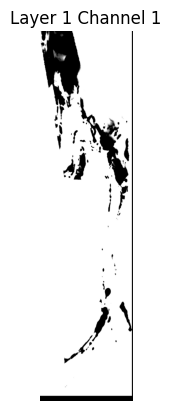

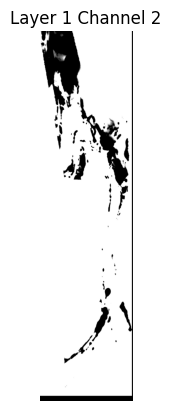

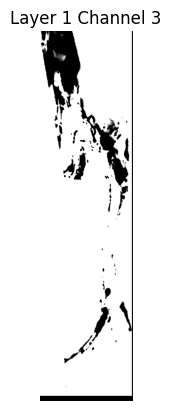

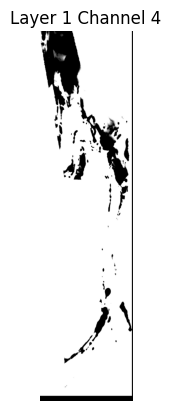

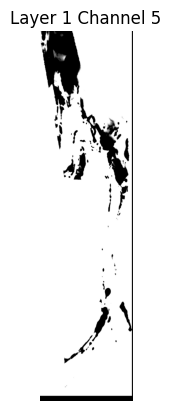

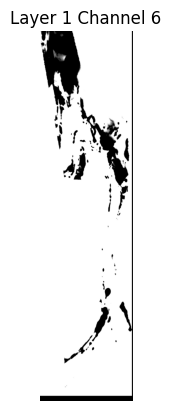

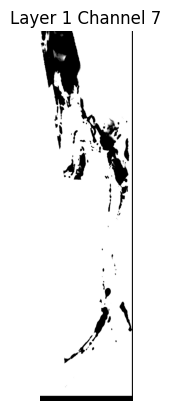

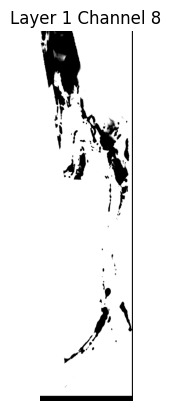

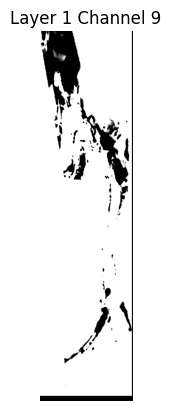

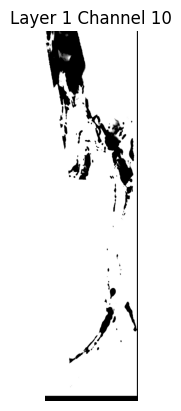

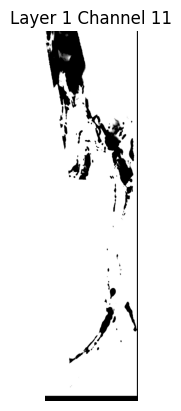

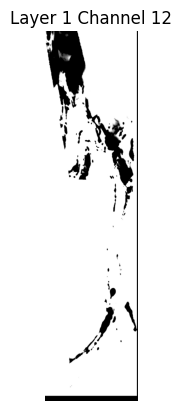

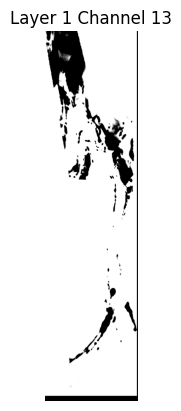

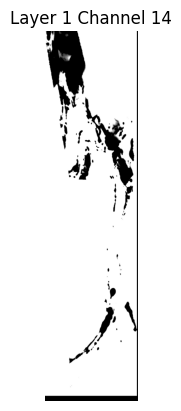

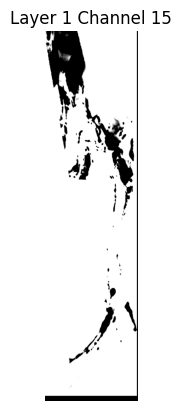

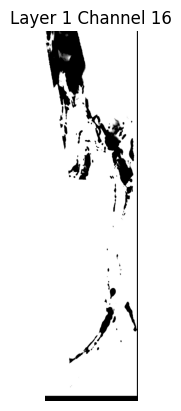

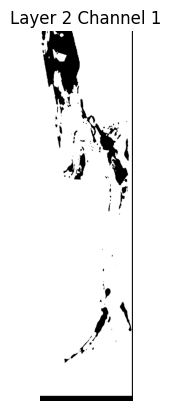

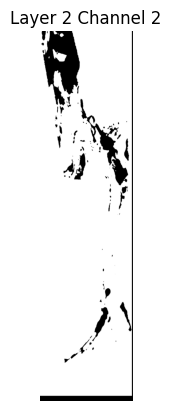

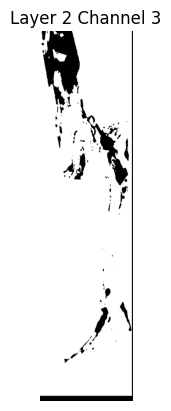

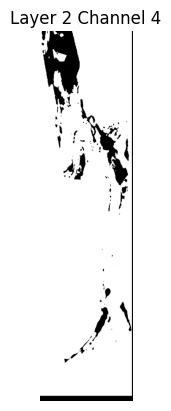

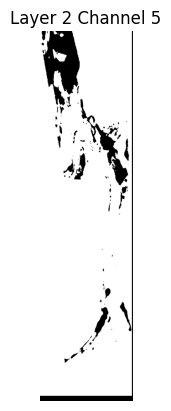

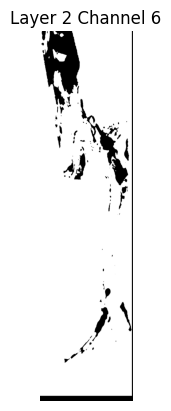

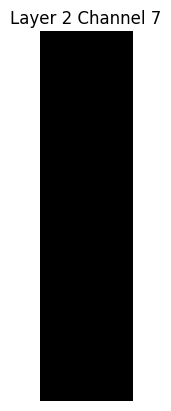

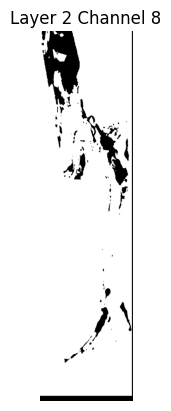

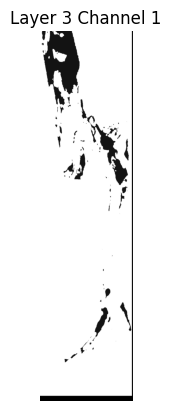

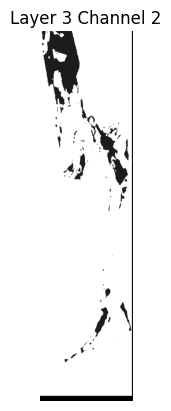

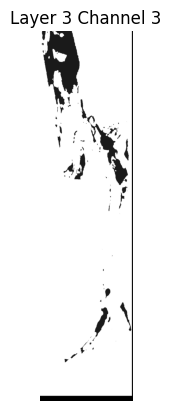

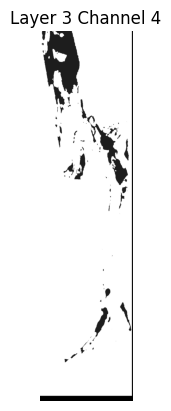

In [21]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory to save the images
save_dir = "/content/drive/MyDrive/IITB/Magntic_Image/padding_new_50x50_stiched_outputs"
os.makedirs(save_dir, exist_ok=True)

# Save and display the individual layer-wise representation images
for i, stitched_image in enumerate(stitched_images):

    for j in range(stitched_image.shape[2]):
        # Create a PIL image from the NumPy array
        img = Image.fromarray(stitched_image[:, :, j])

        # Convert the image to RGB mode
        img = img.convert('RGB')

        # Display the image
        plt.imshow(img)
        plt.title(f"Layer {i+1} Channel {j+1}")
        plt.axis('off')
        plt.show()

        # Save the image
        save_path = os.path.join(save_dir, f"Layer_{i+1}_Channel_{j+1}.png")
        #img.save(save_path)


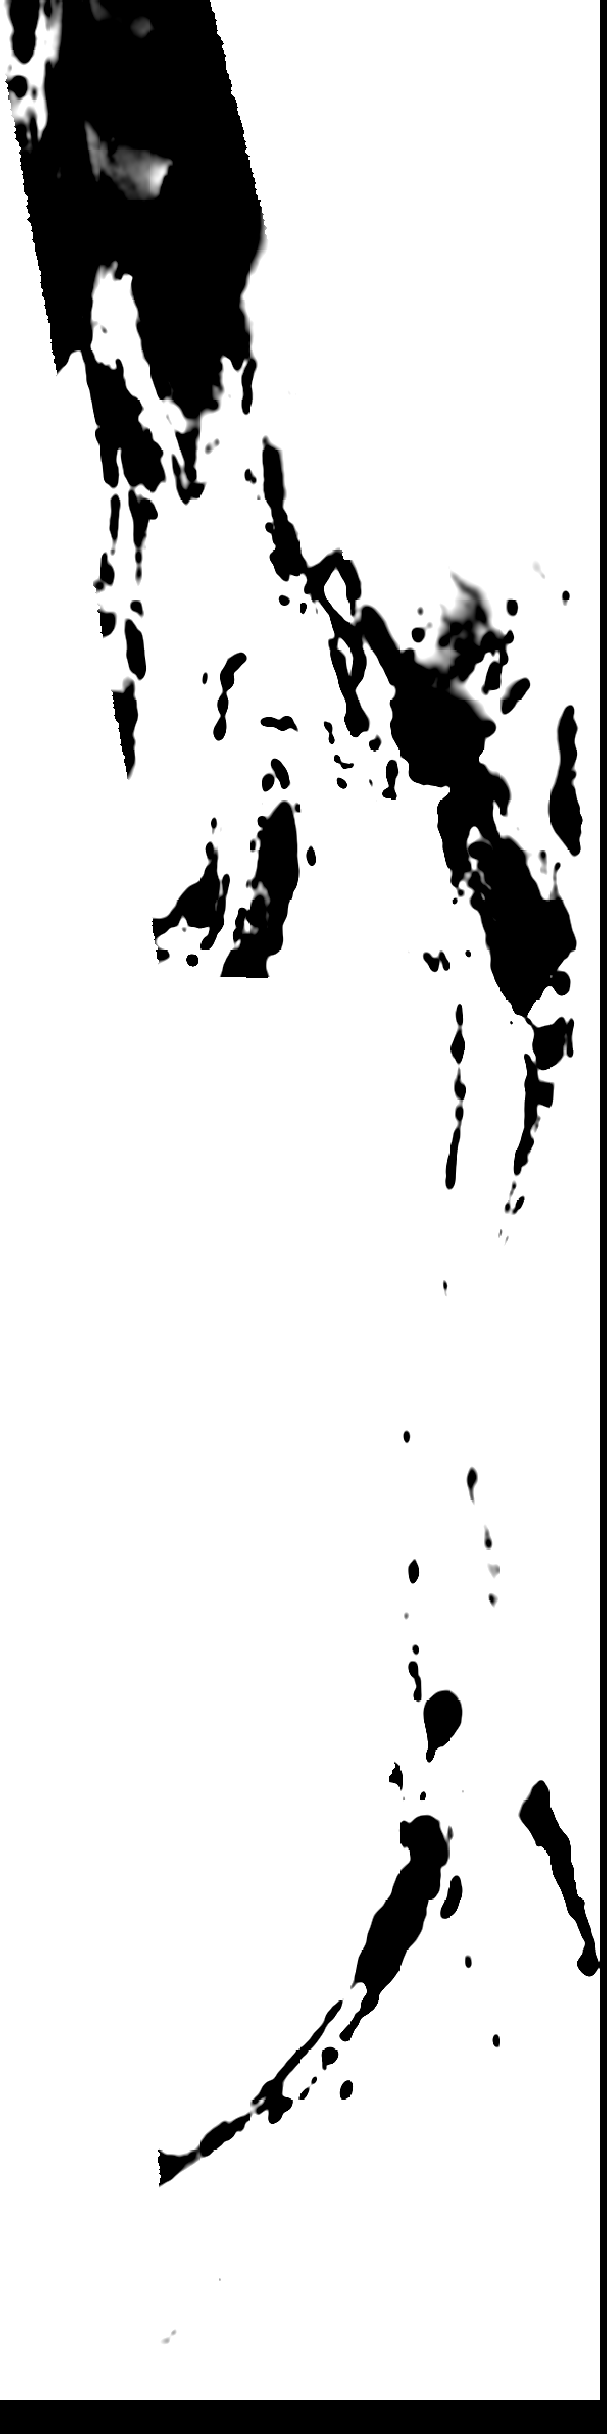

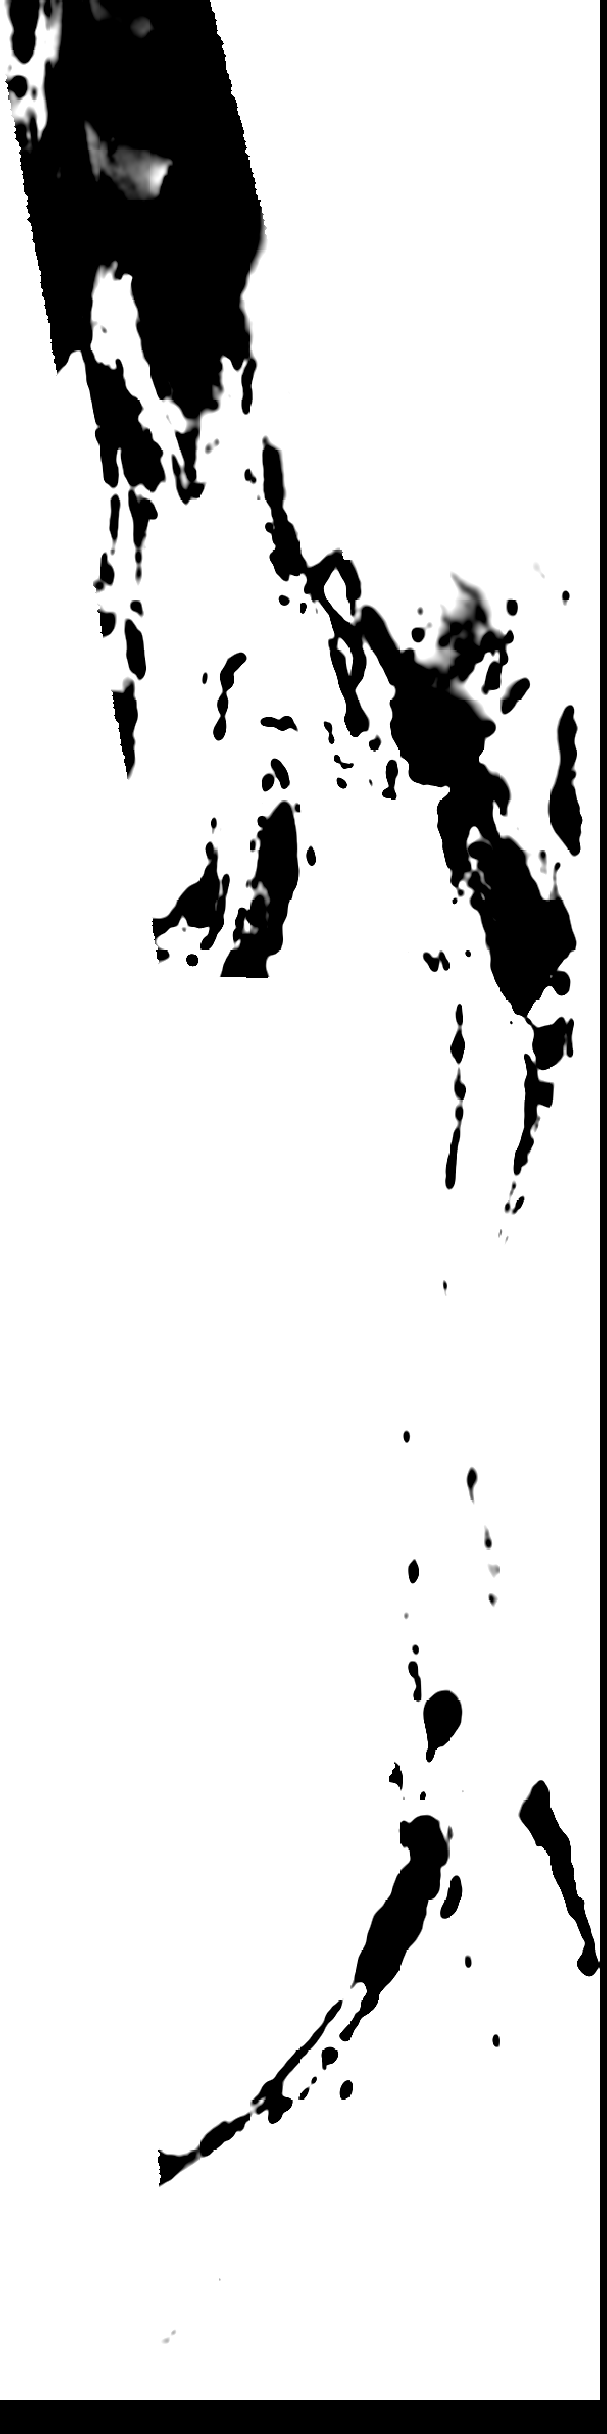

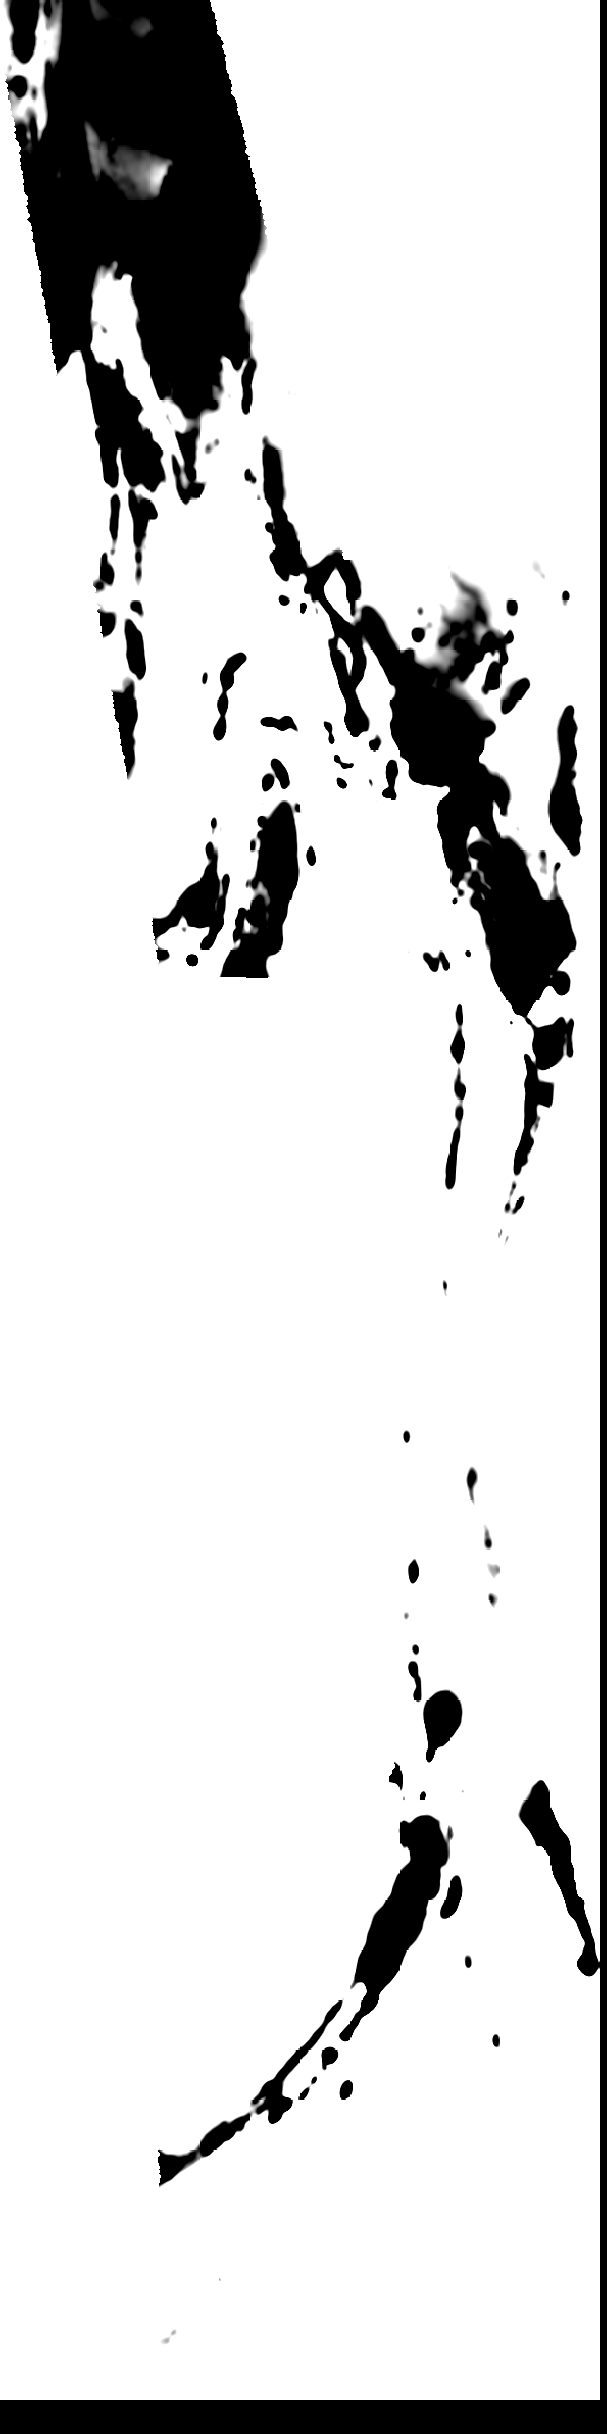

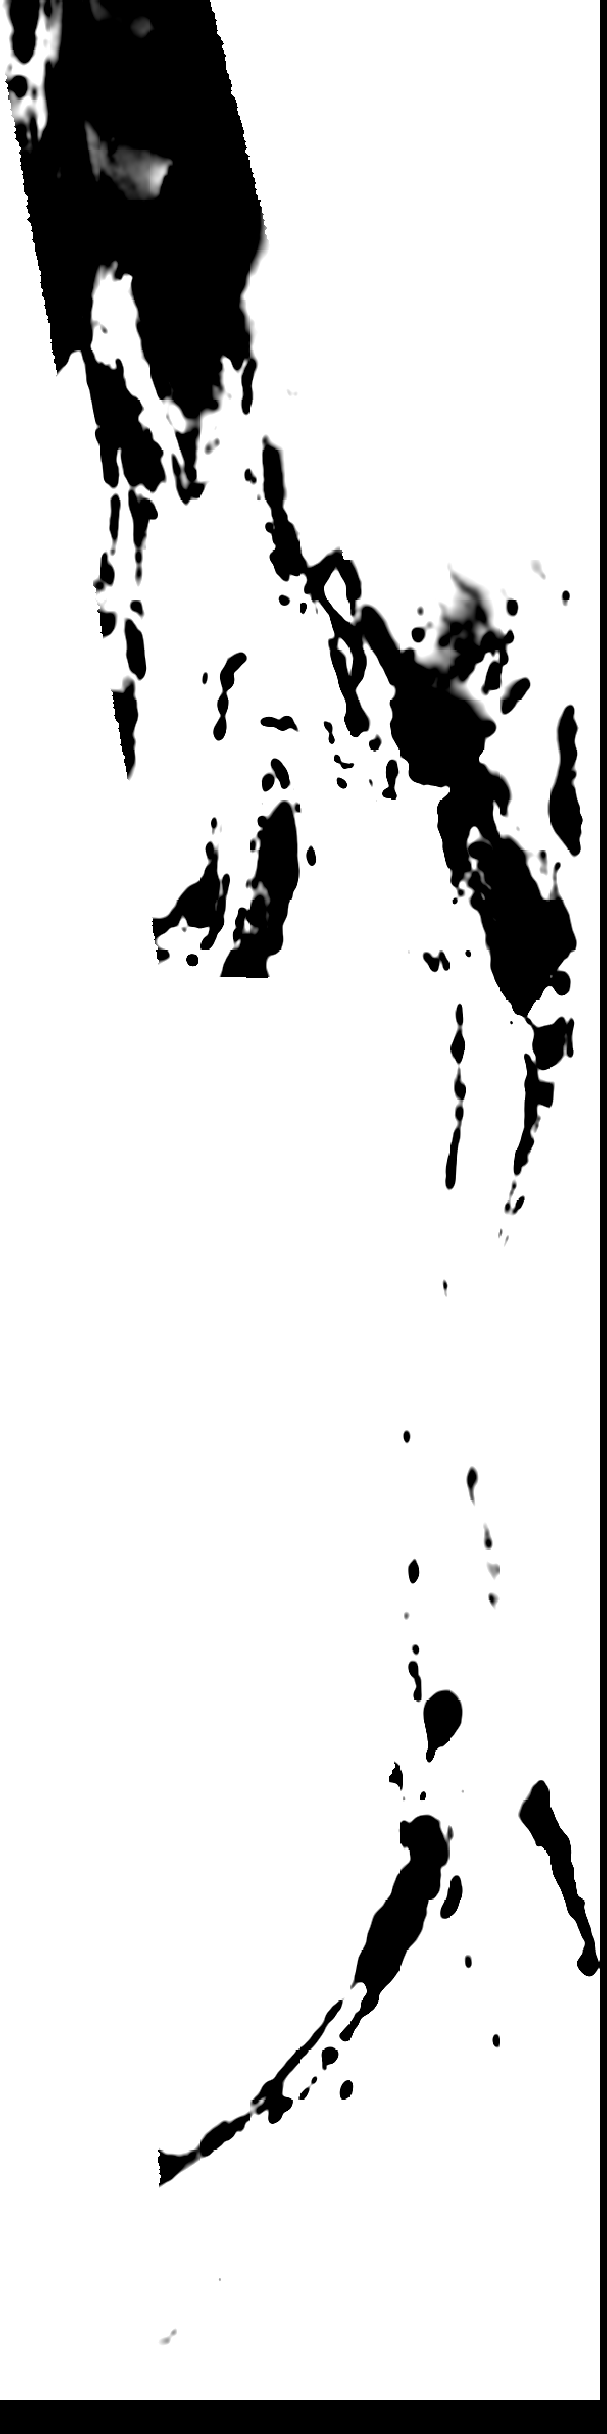

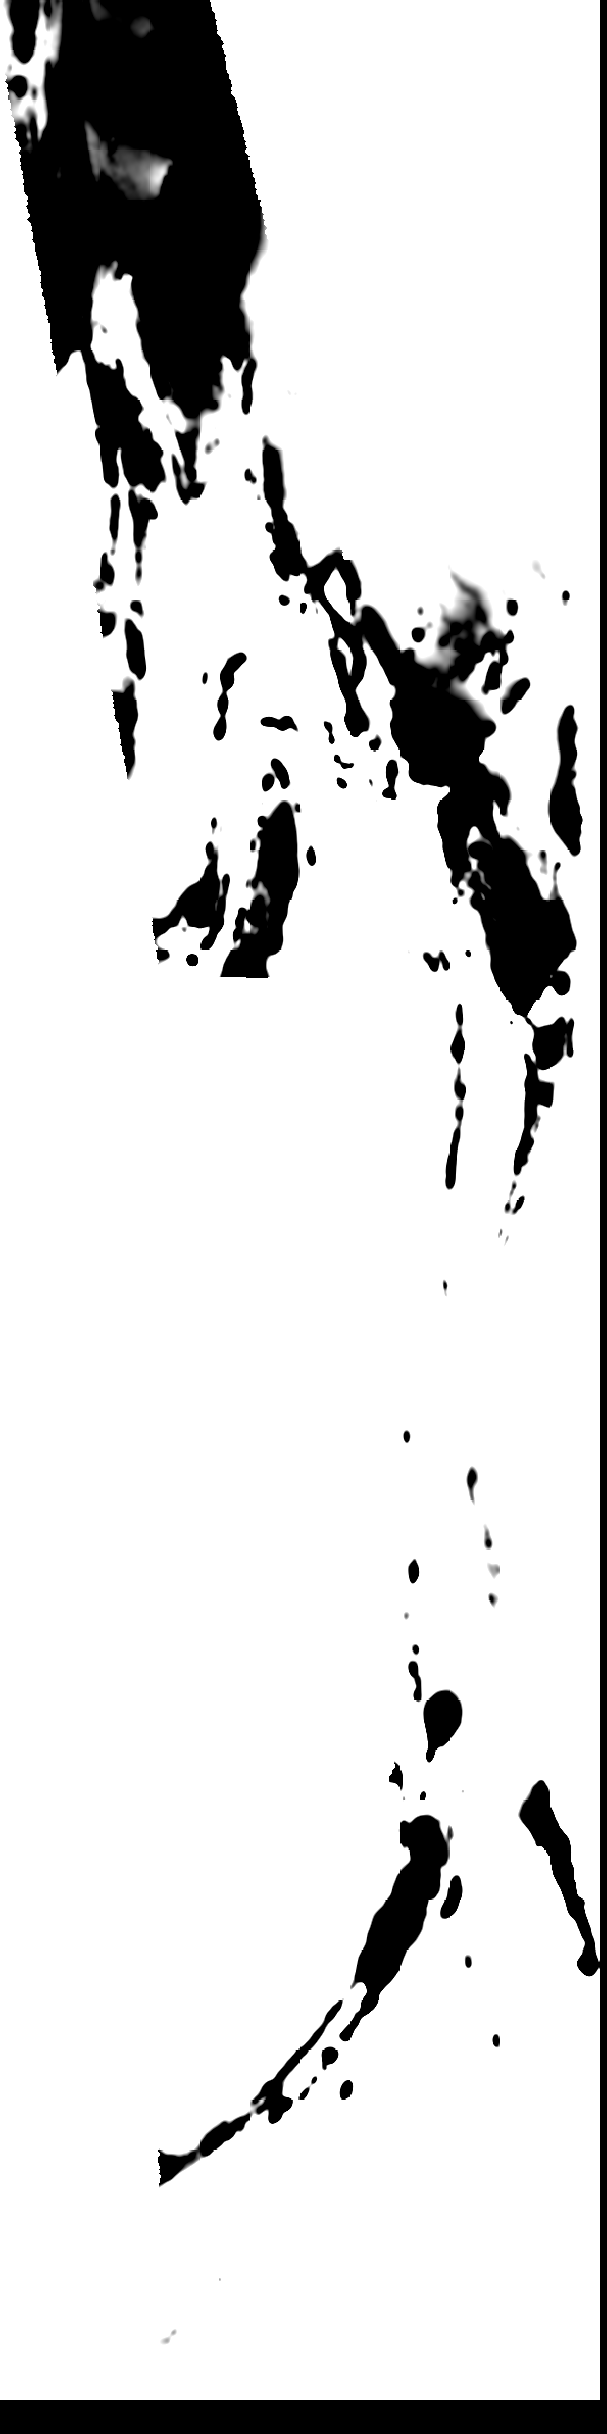

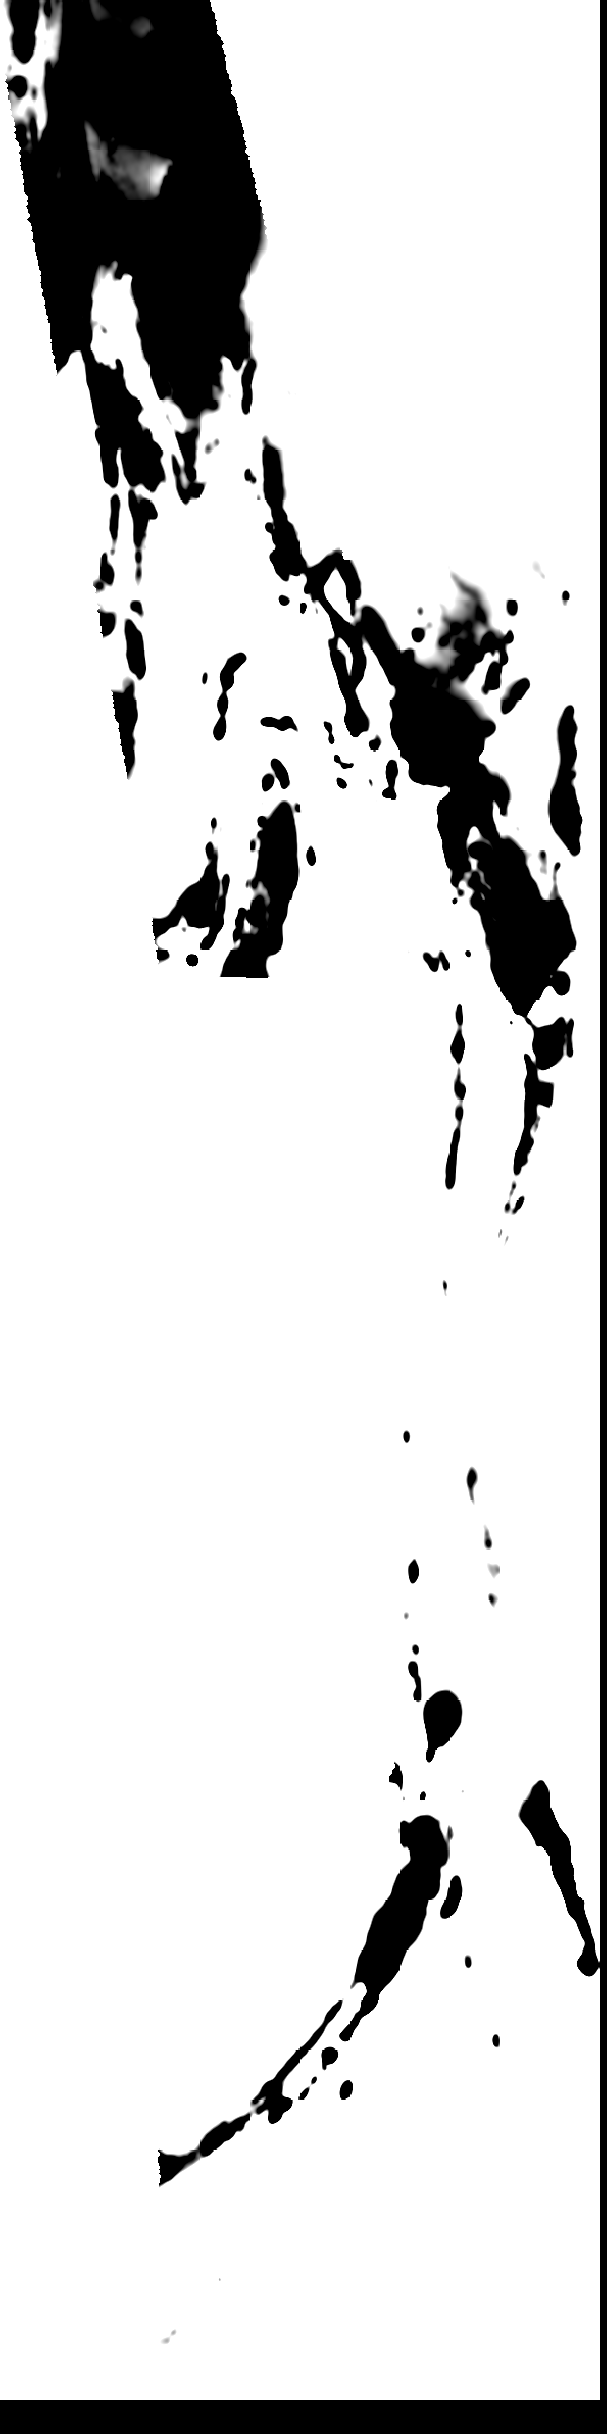

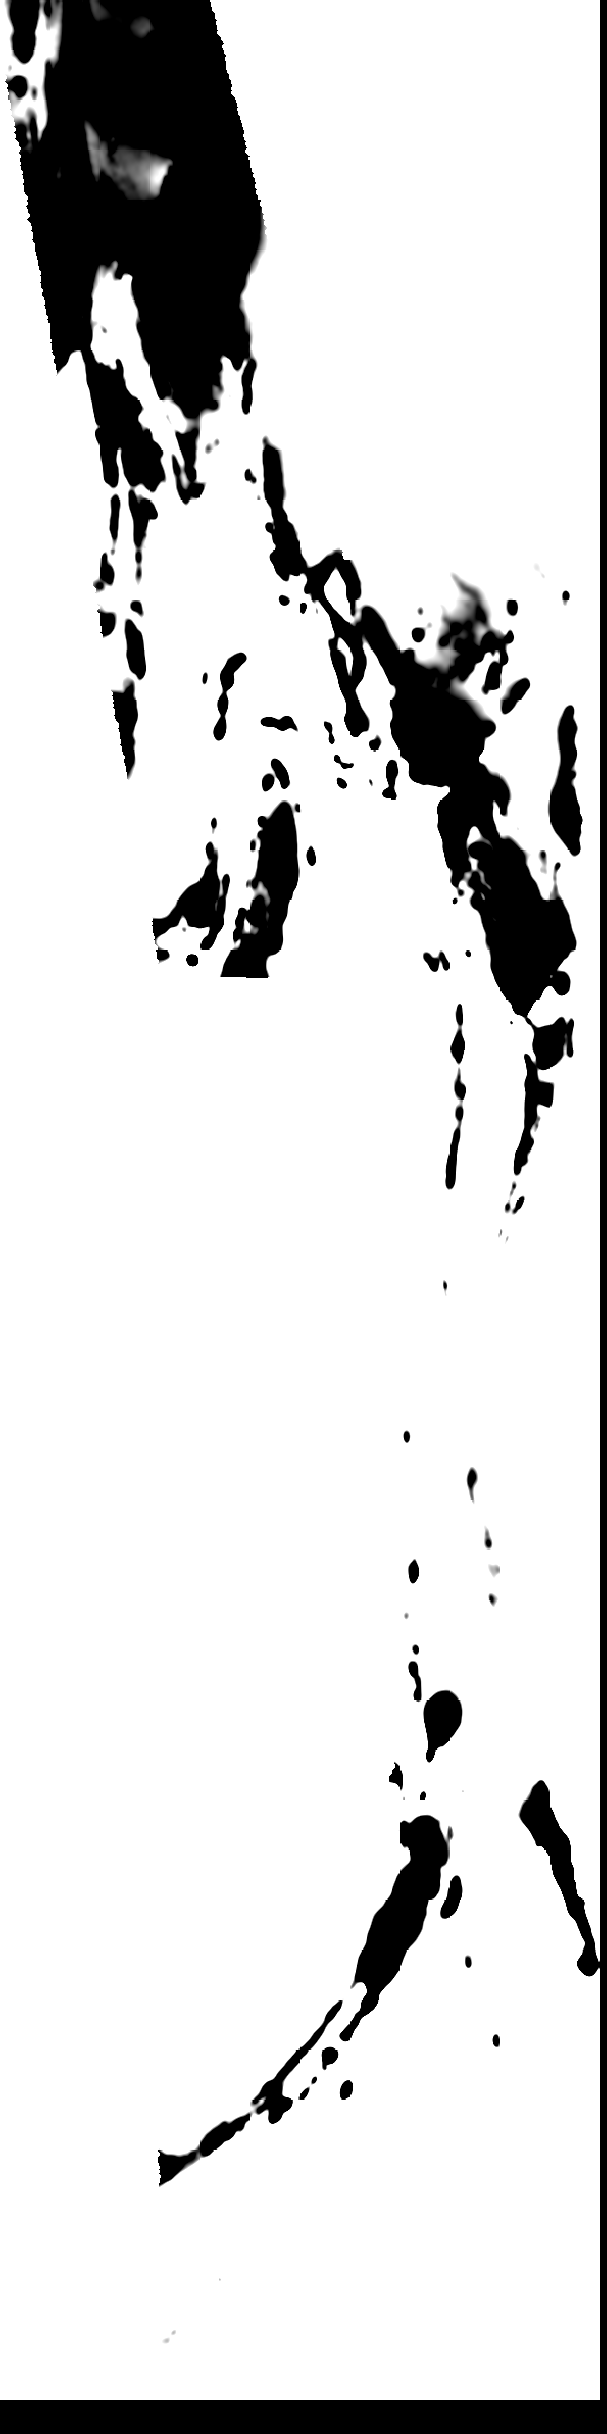

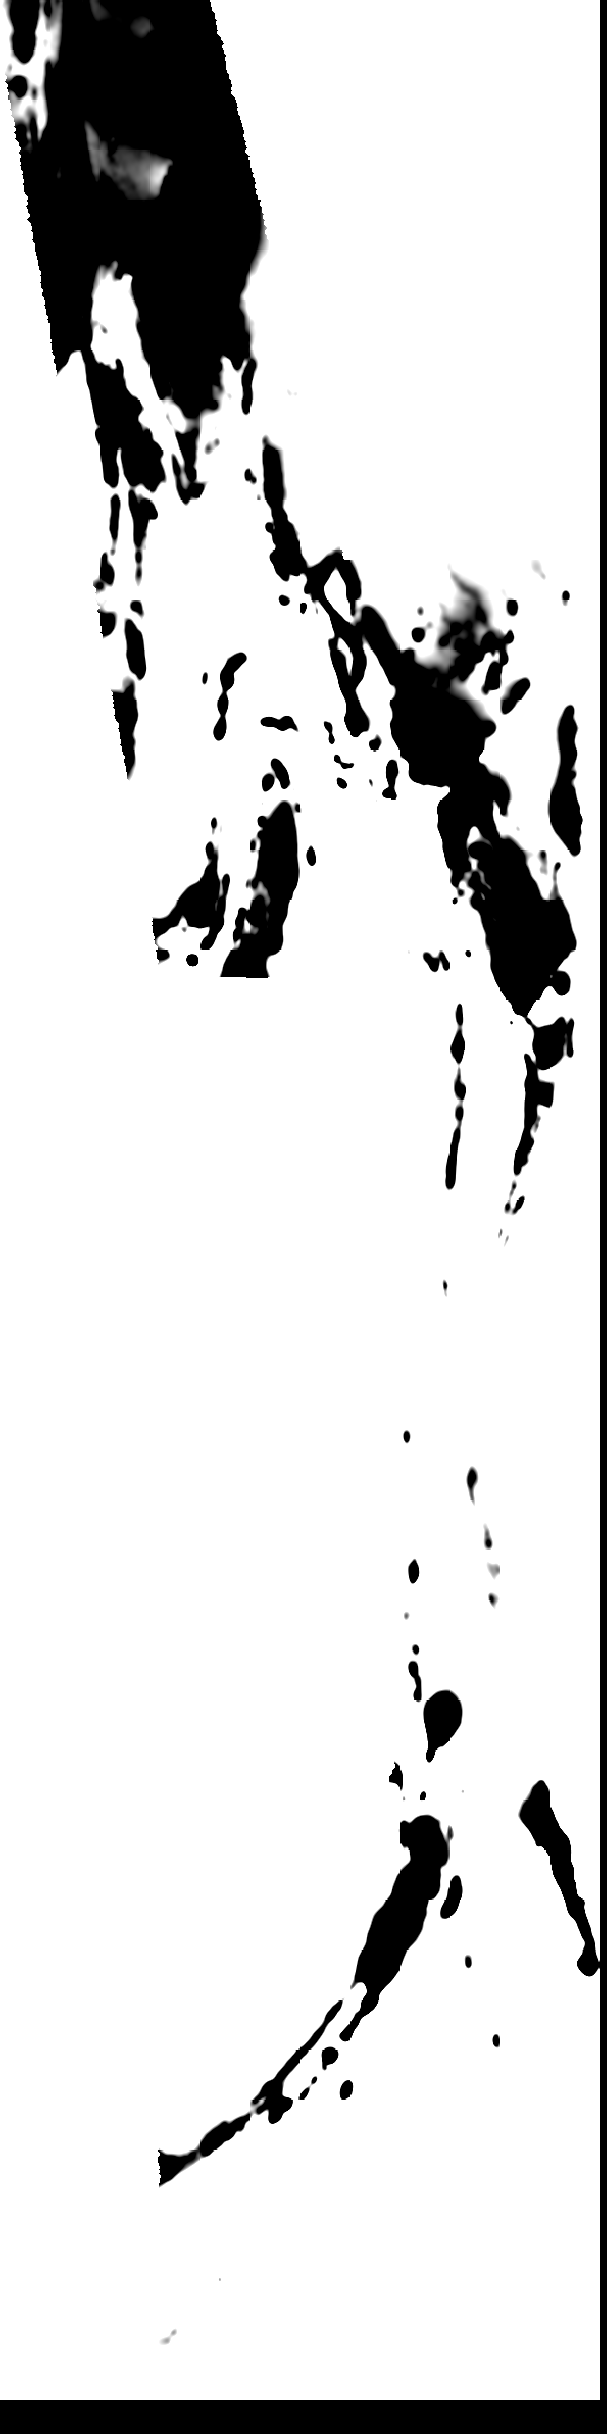

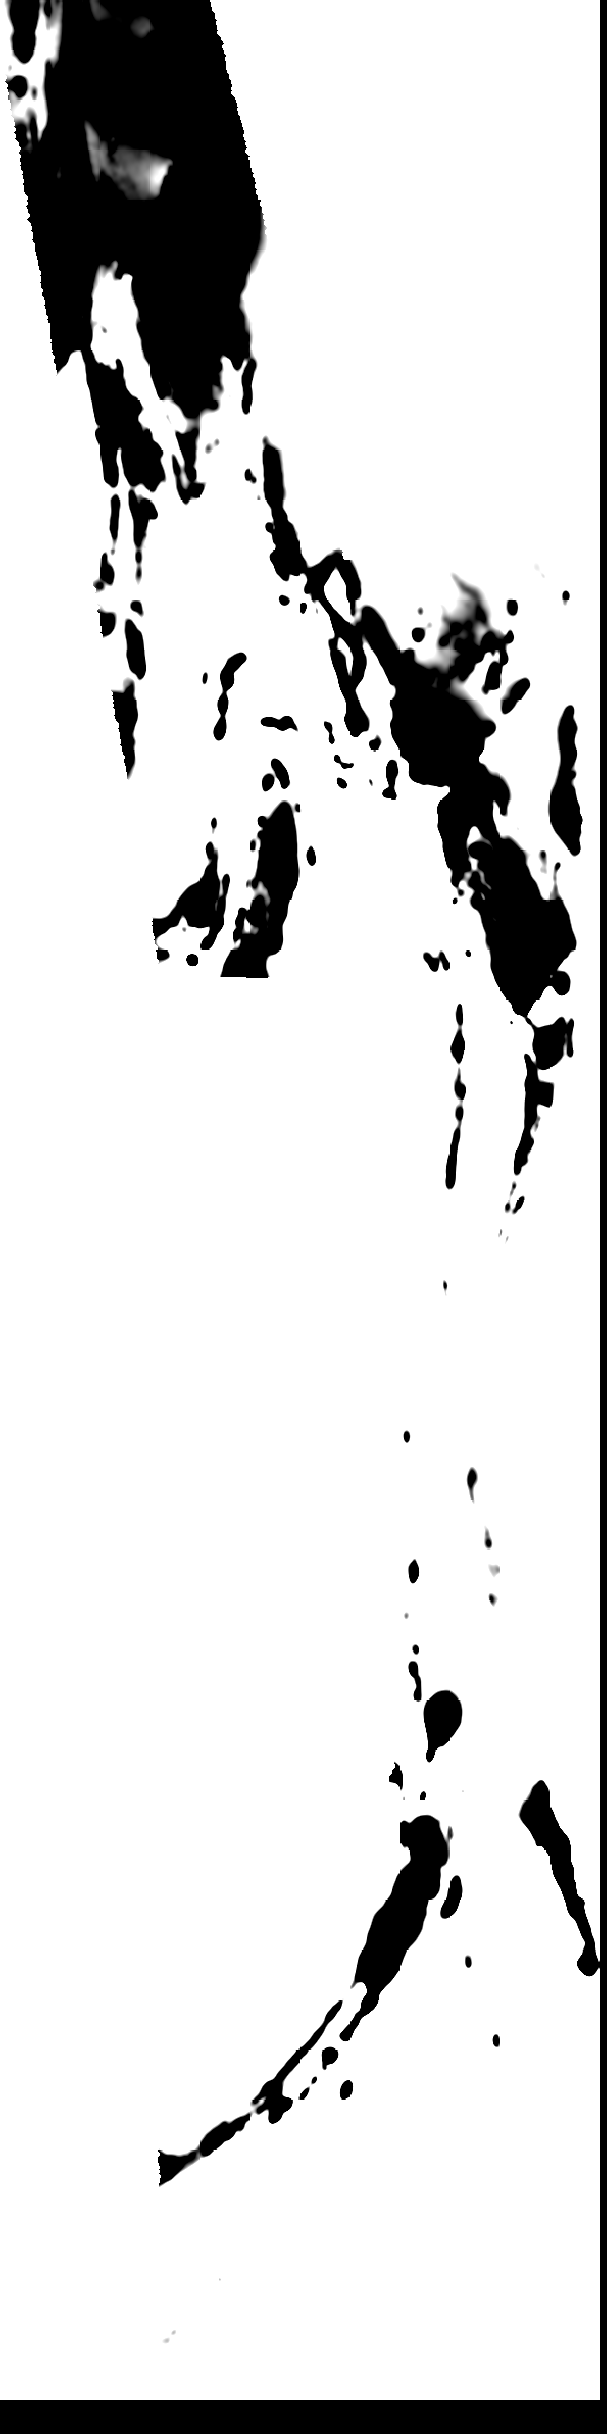

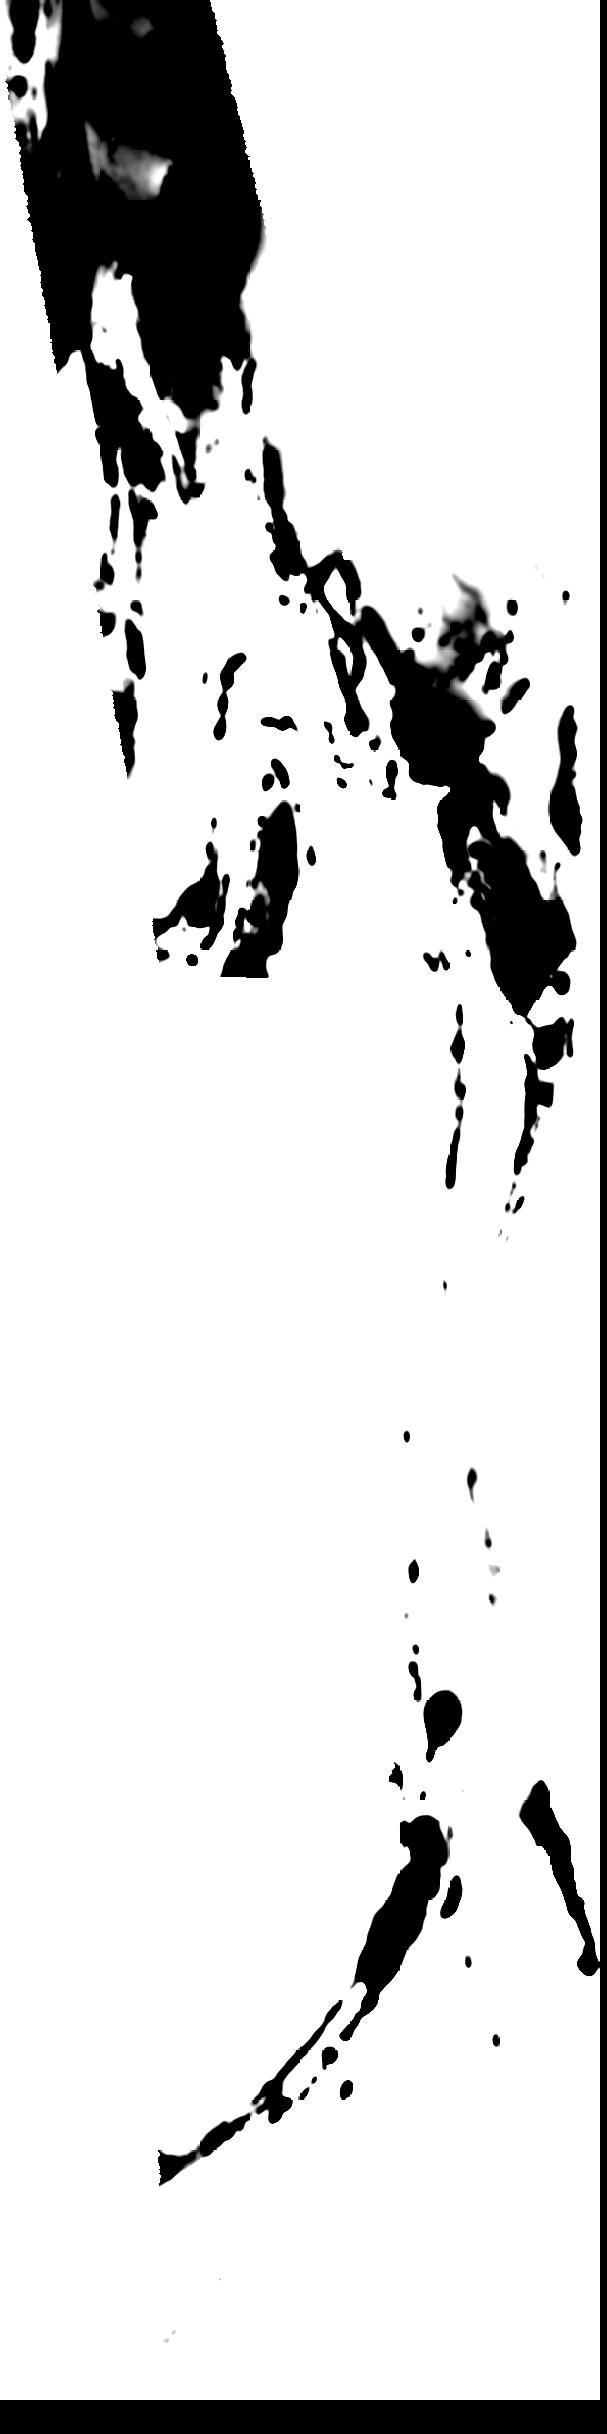

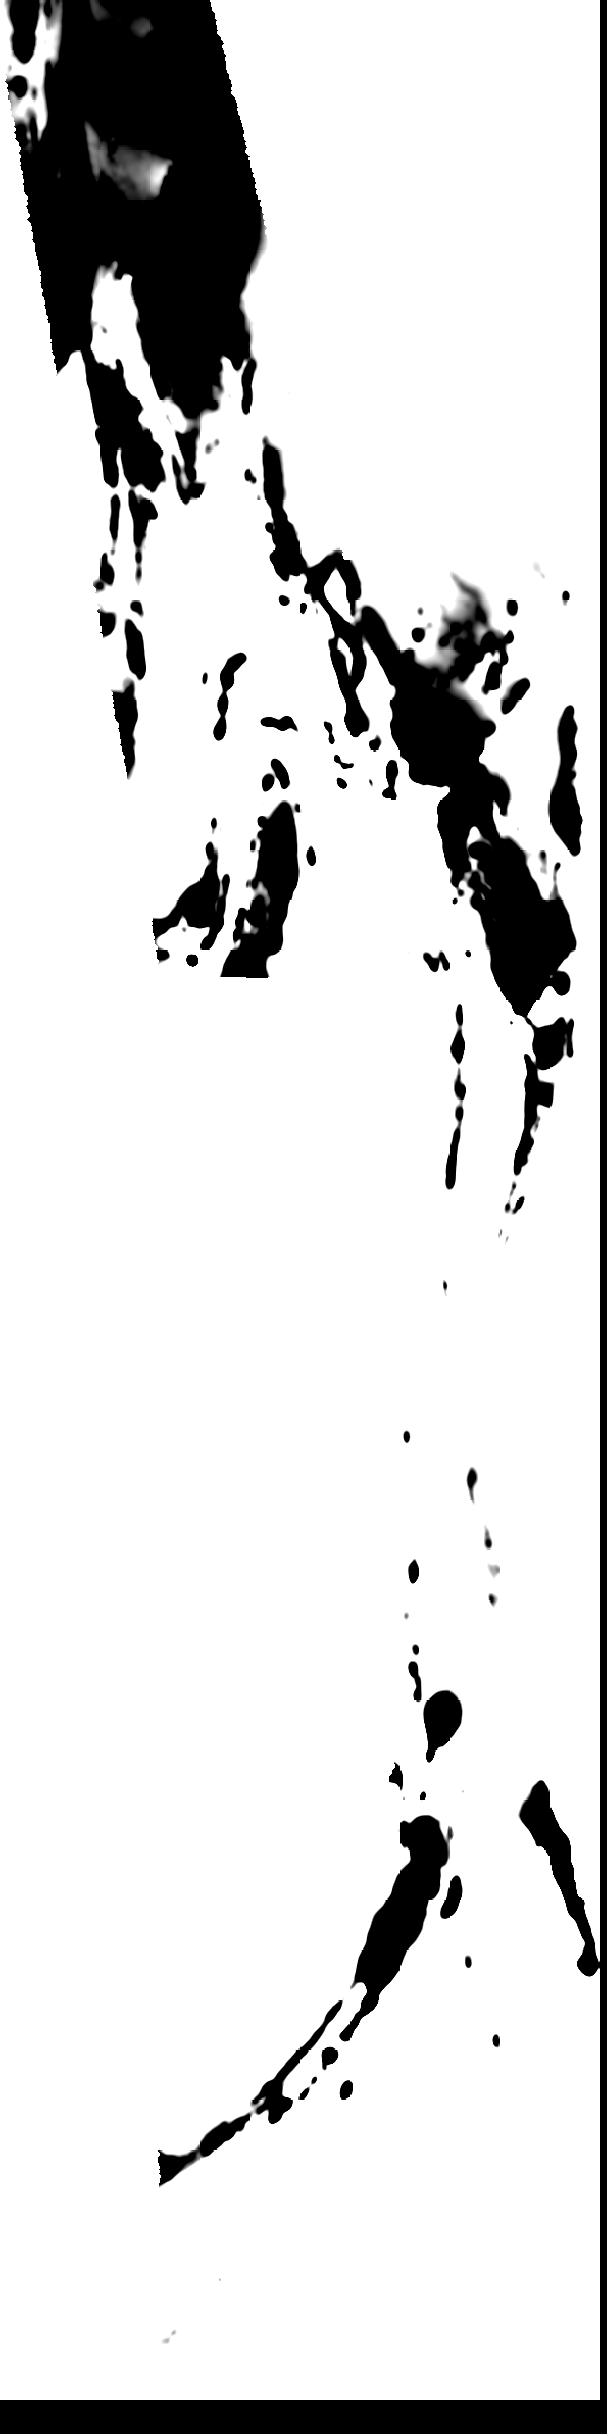

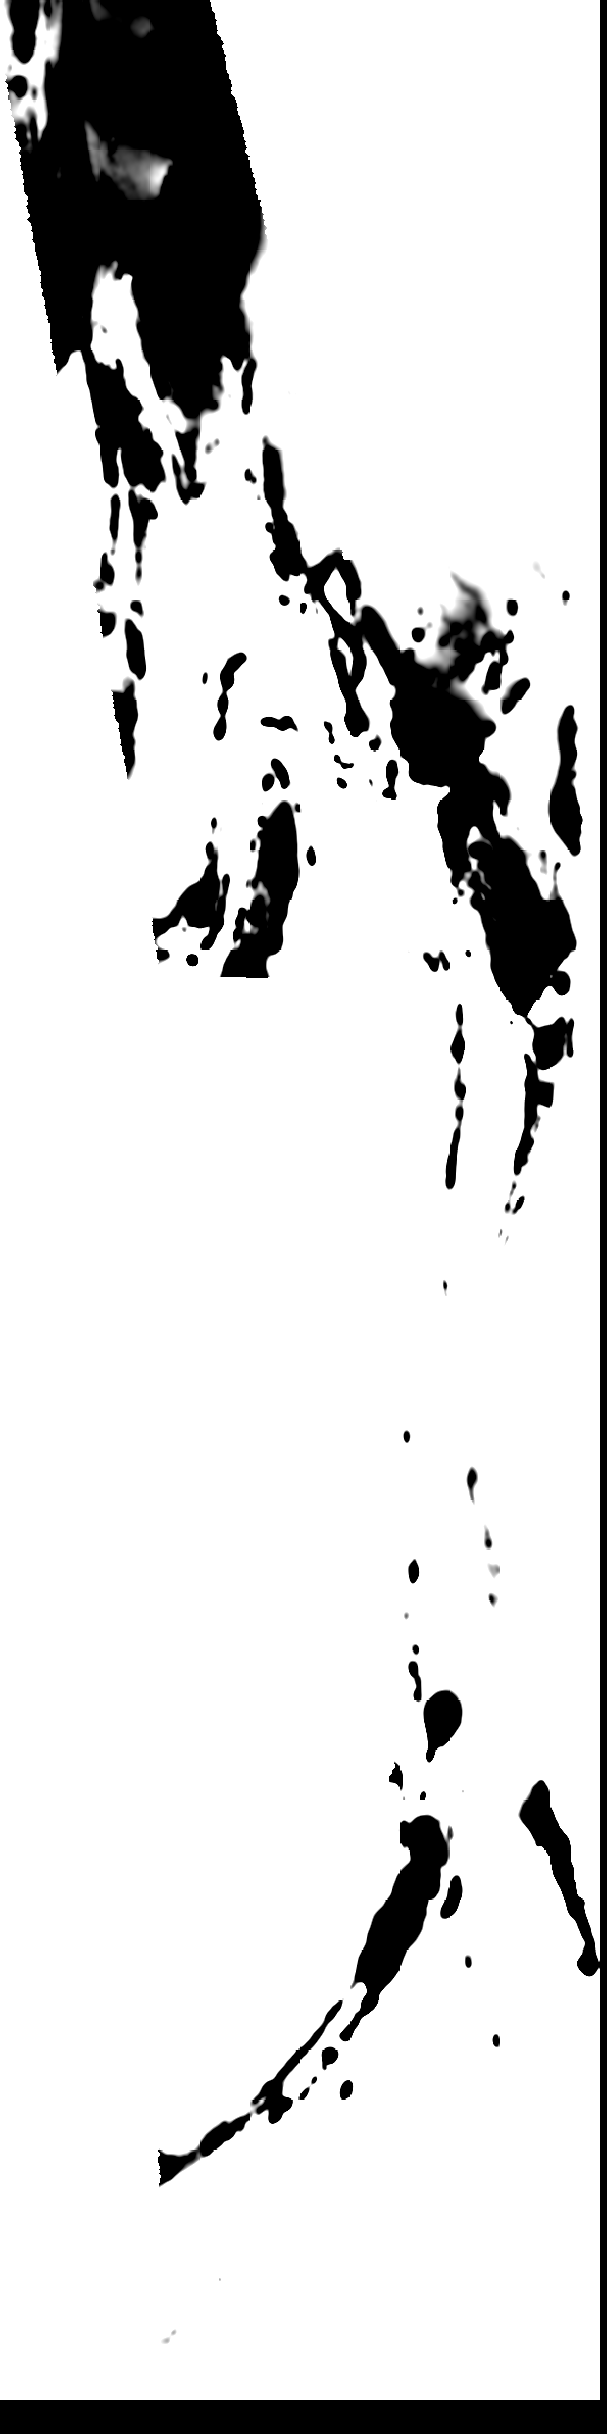

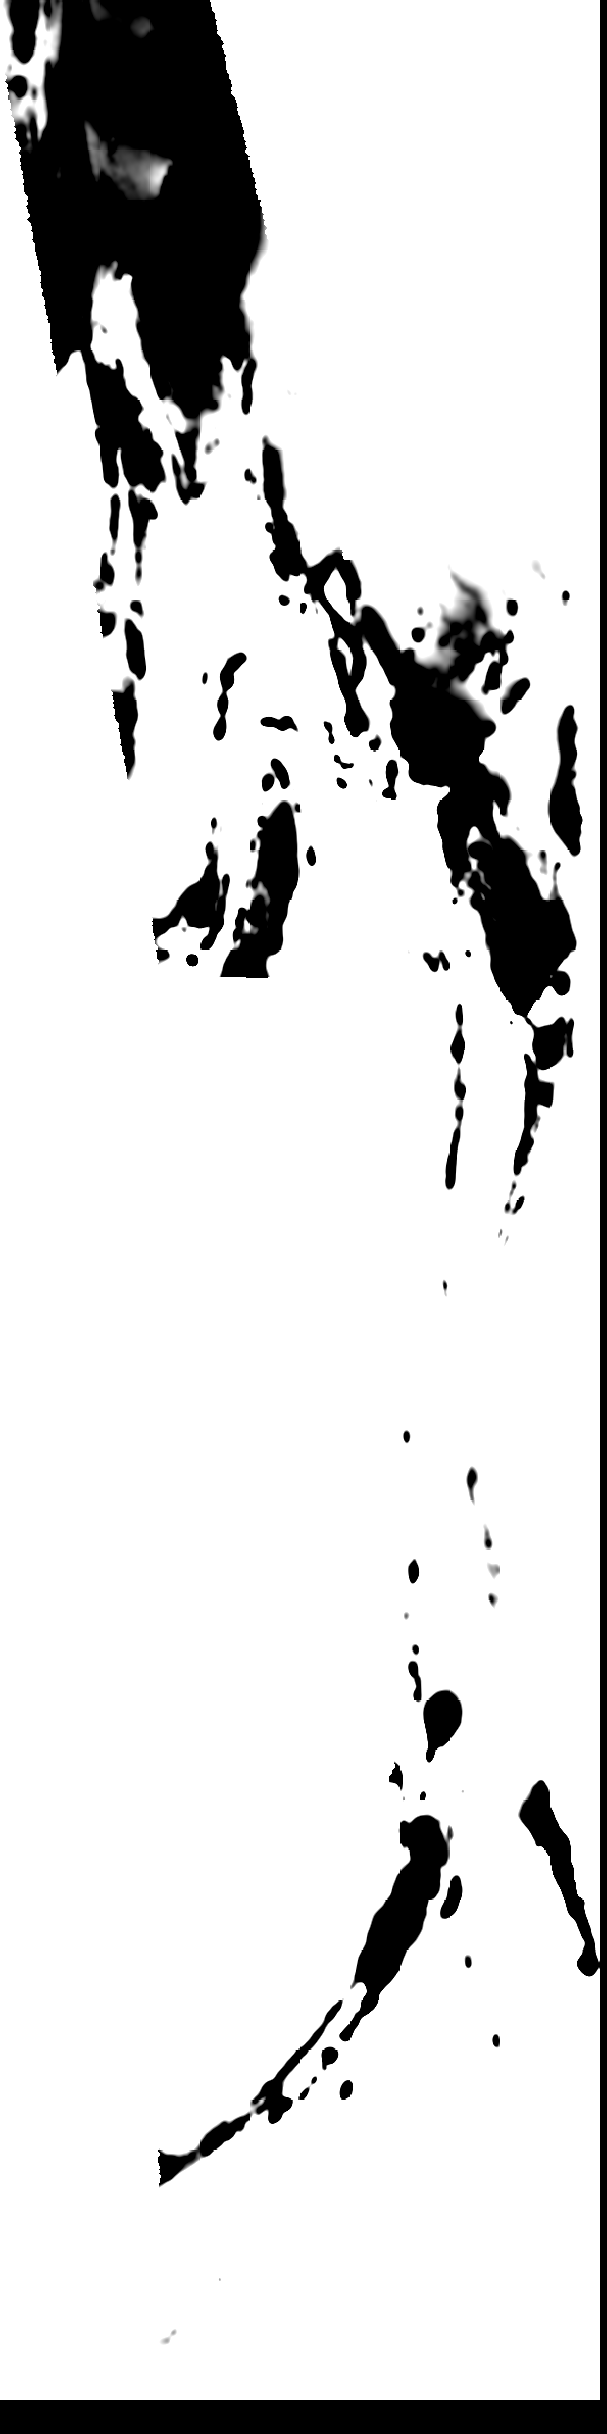

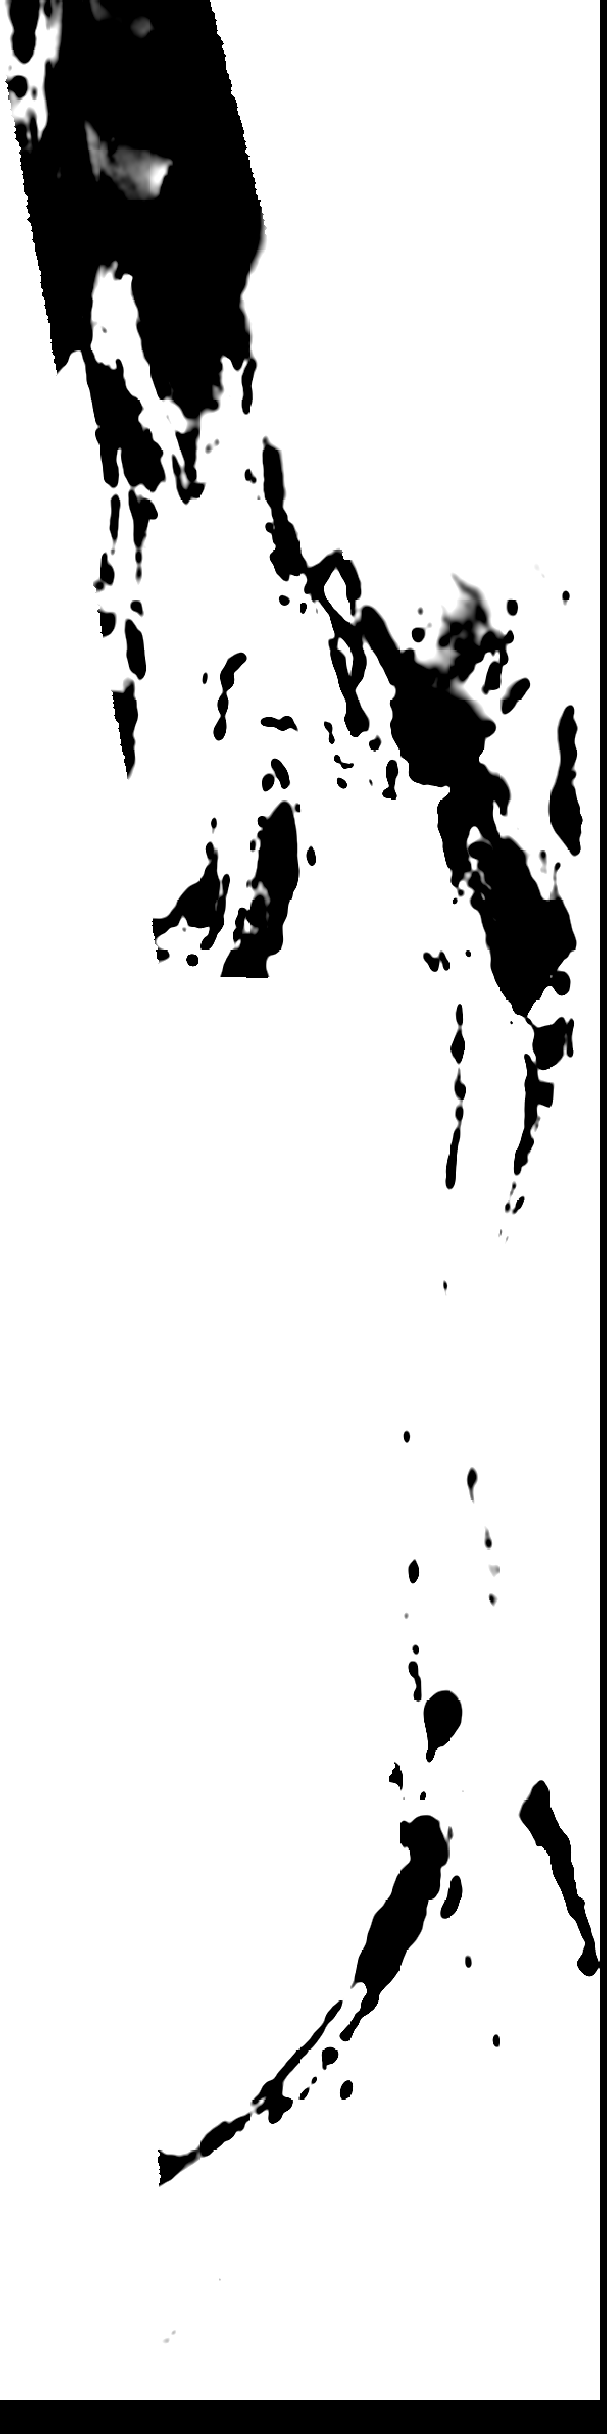

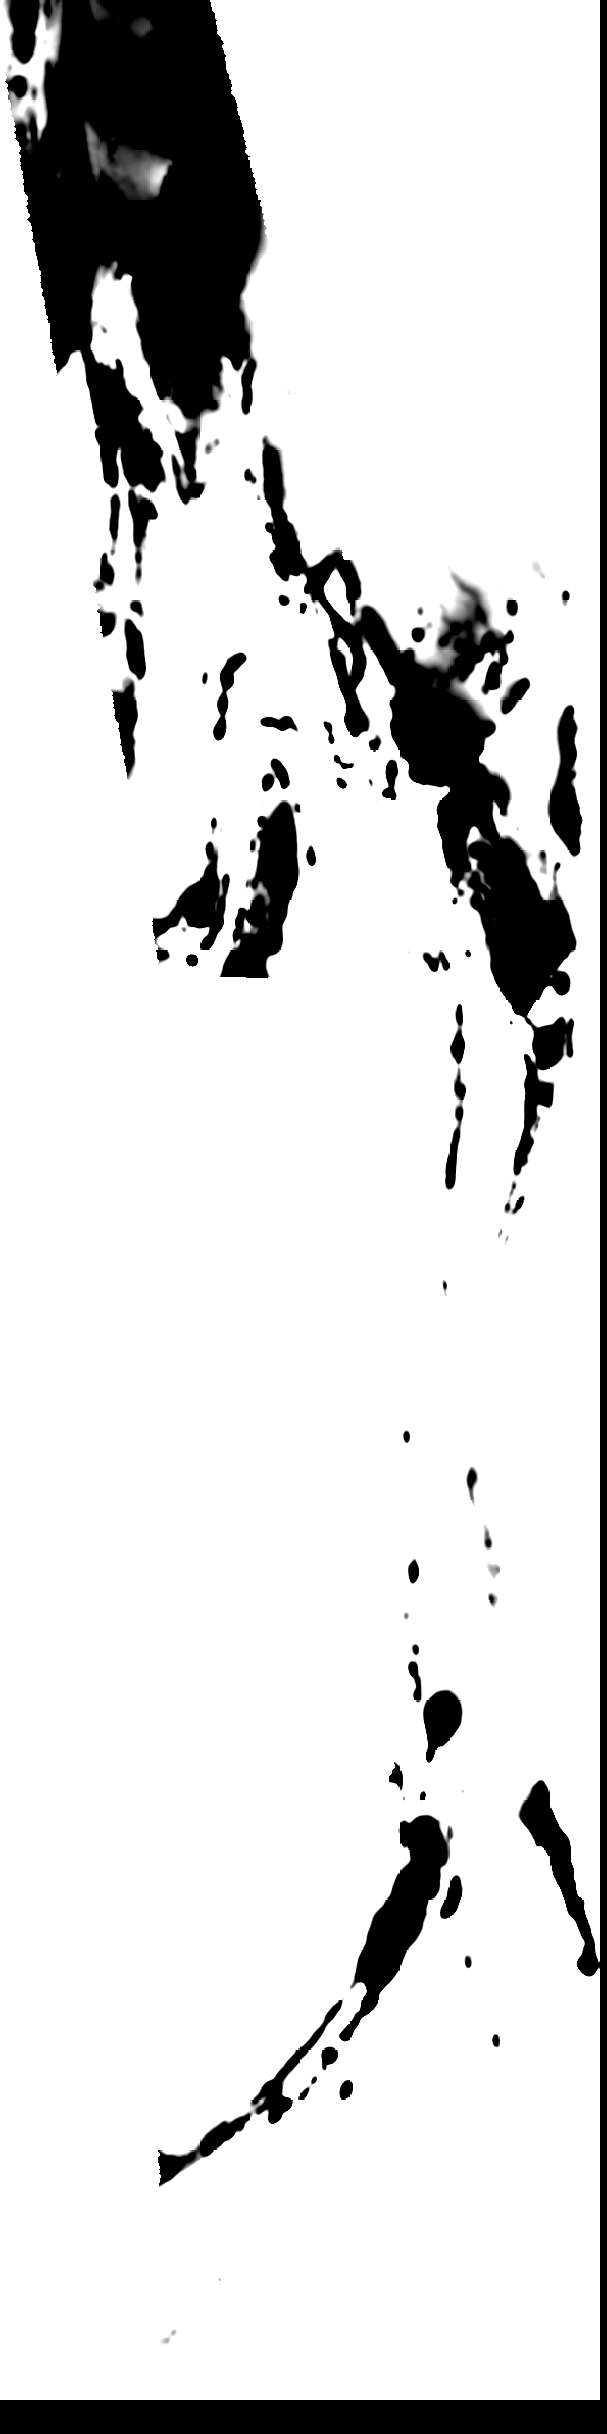

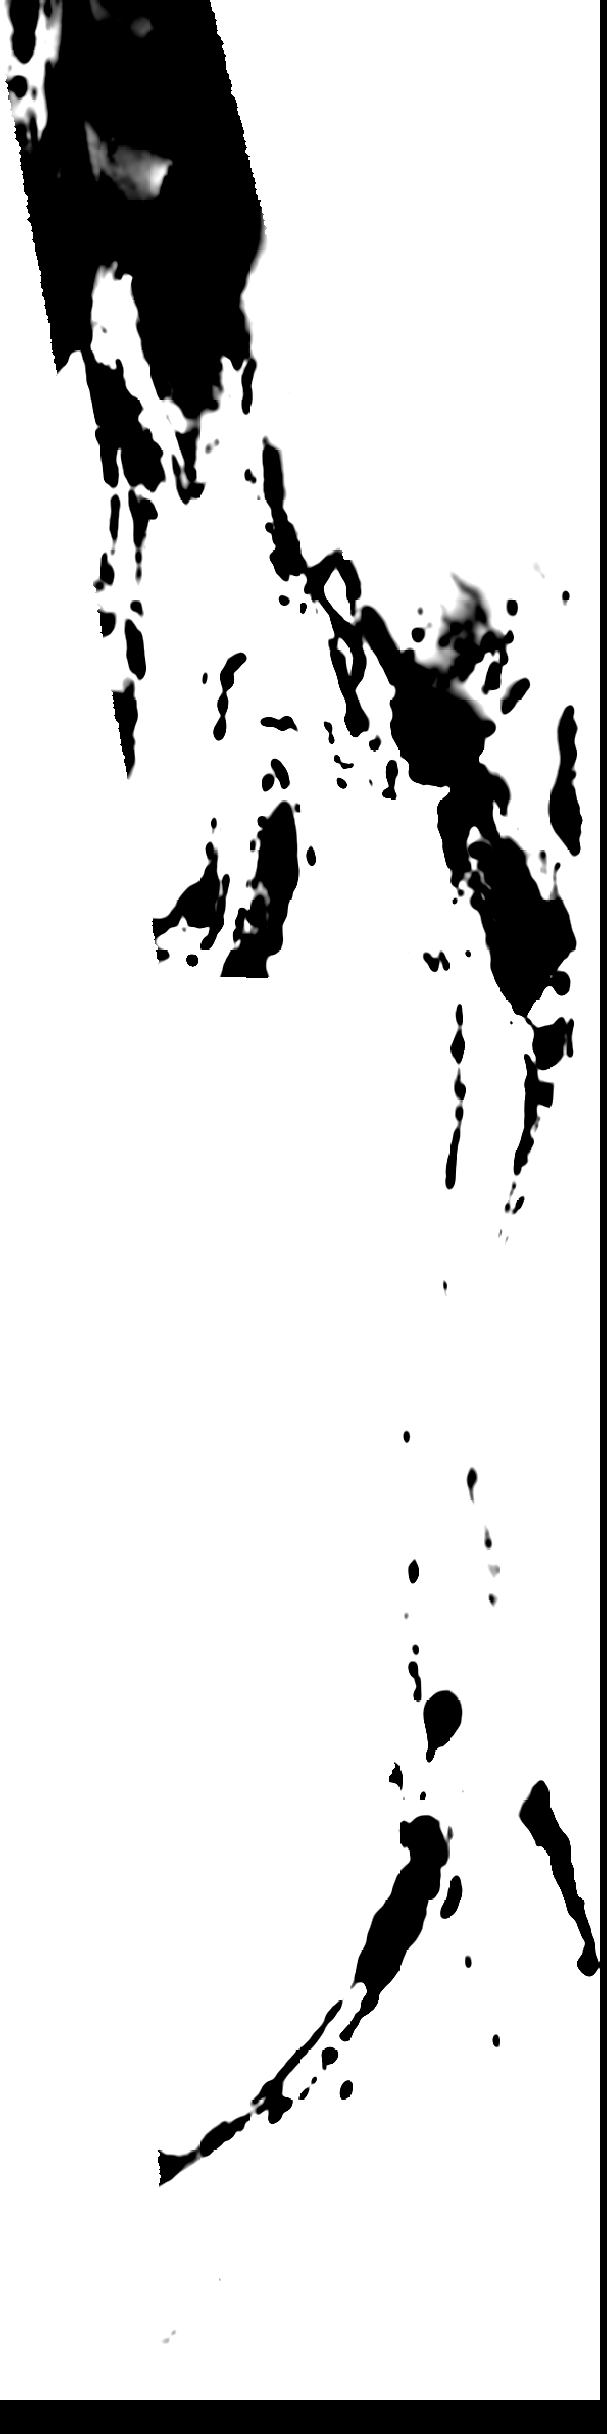

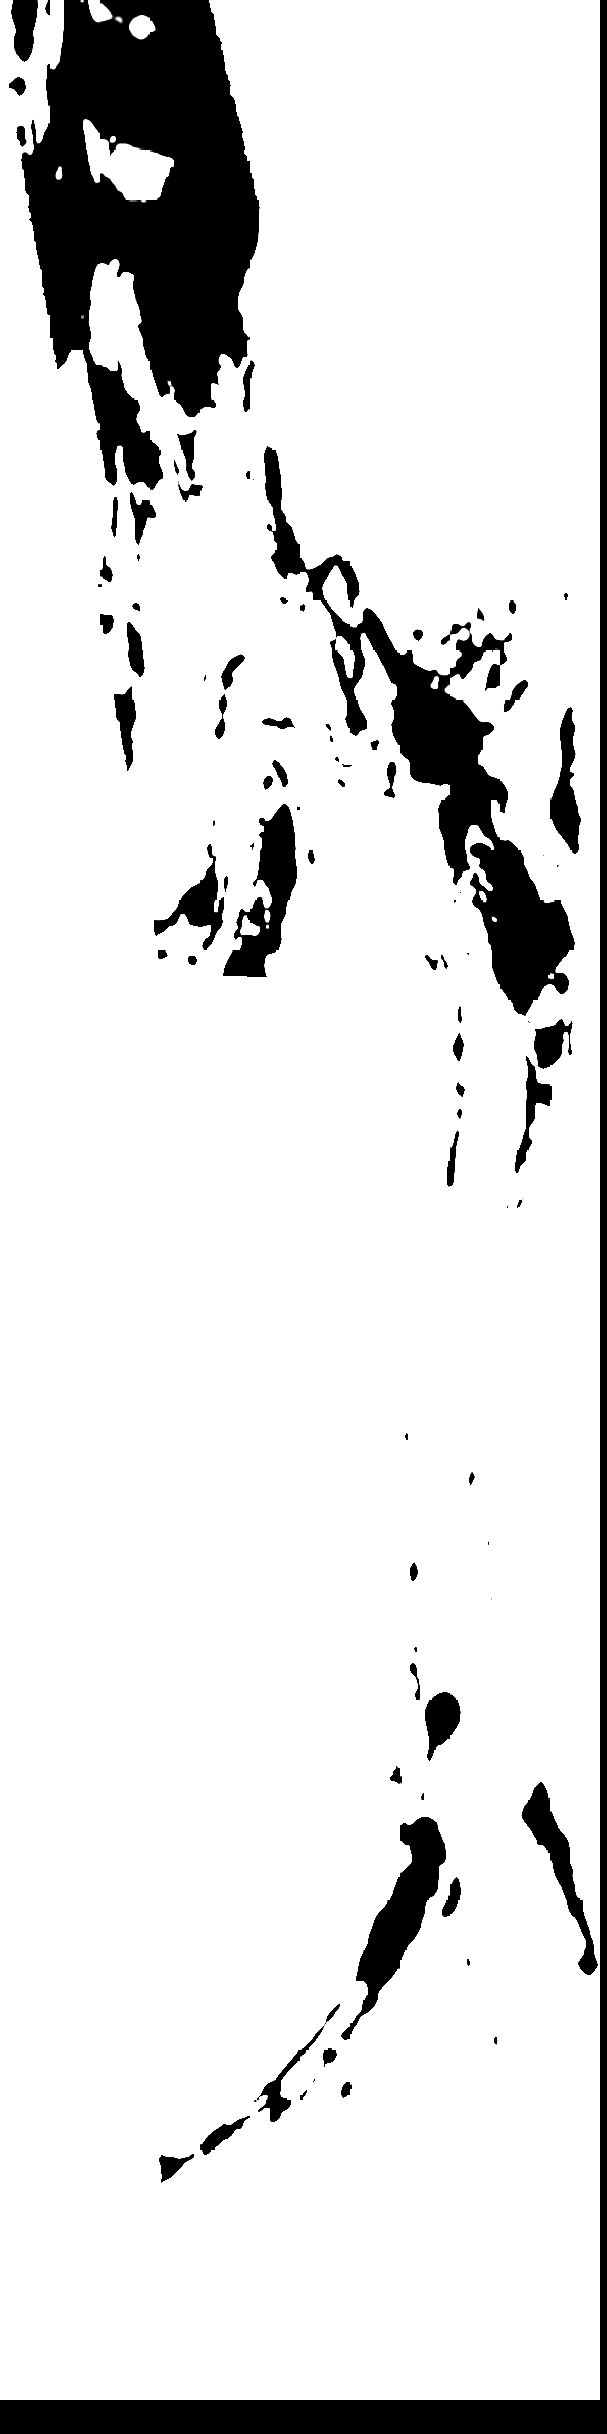

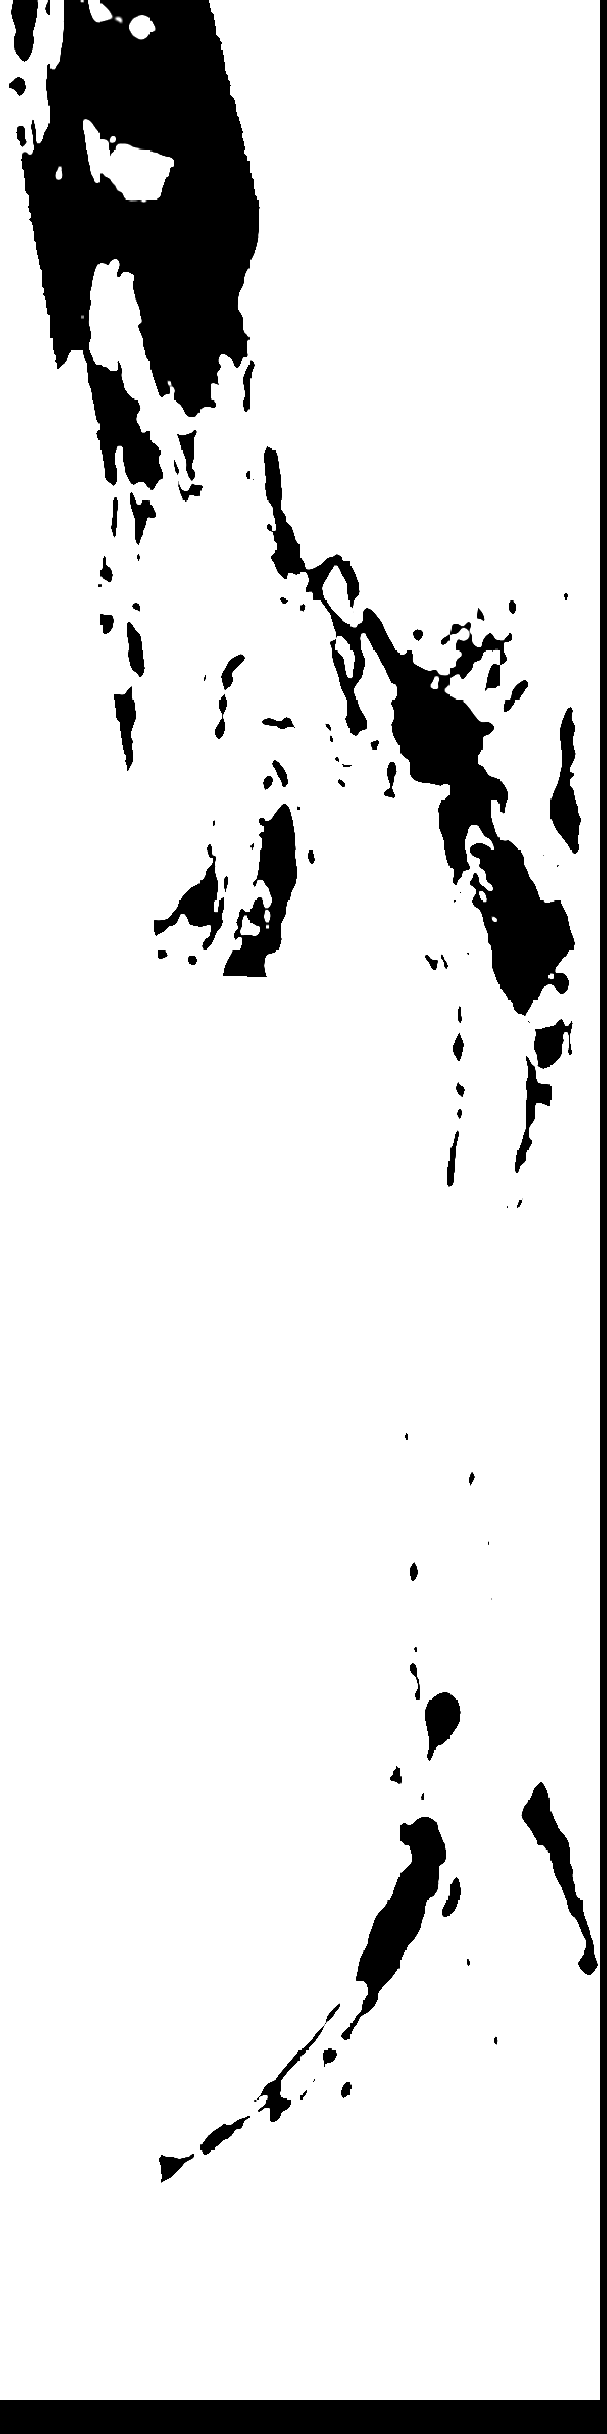

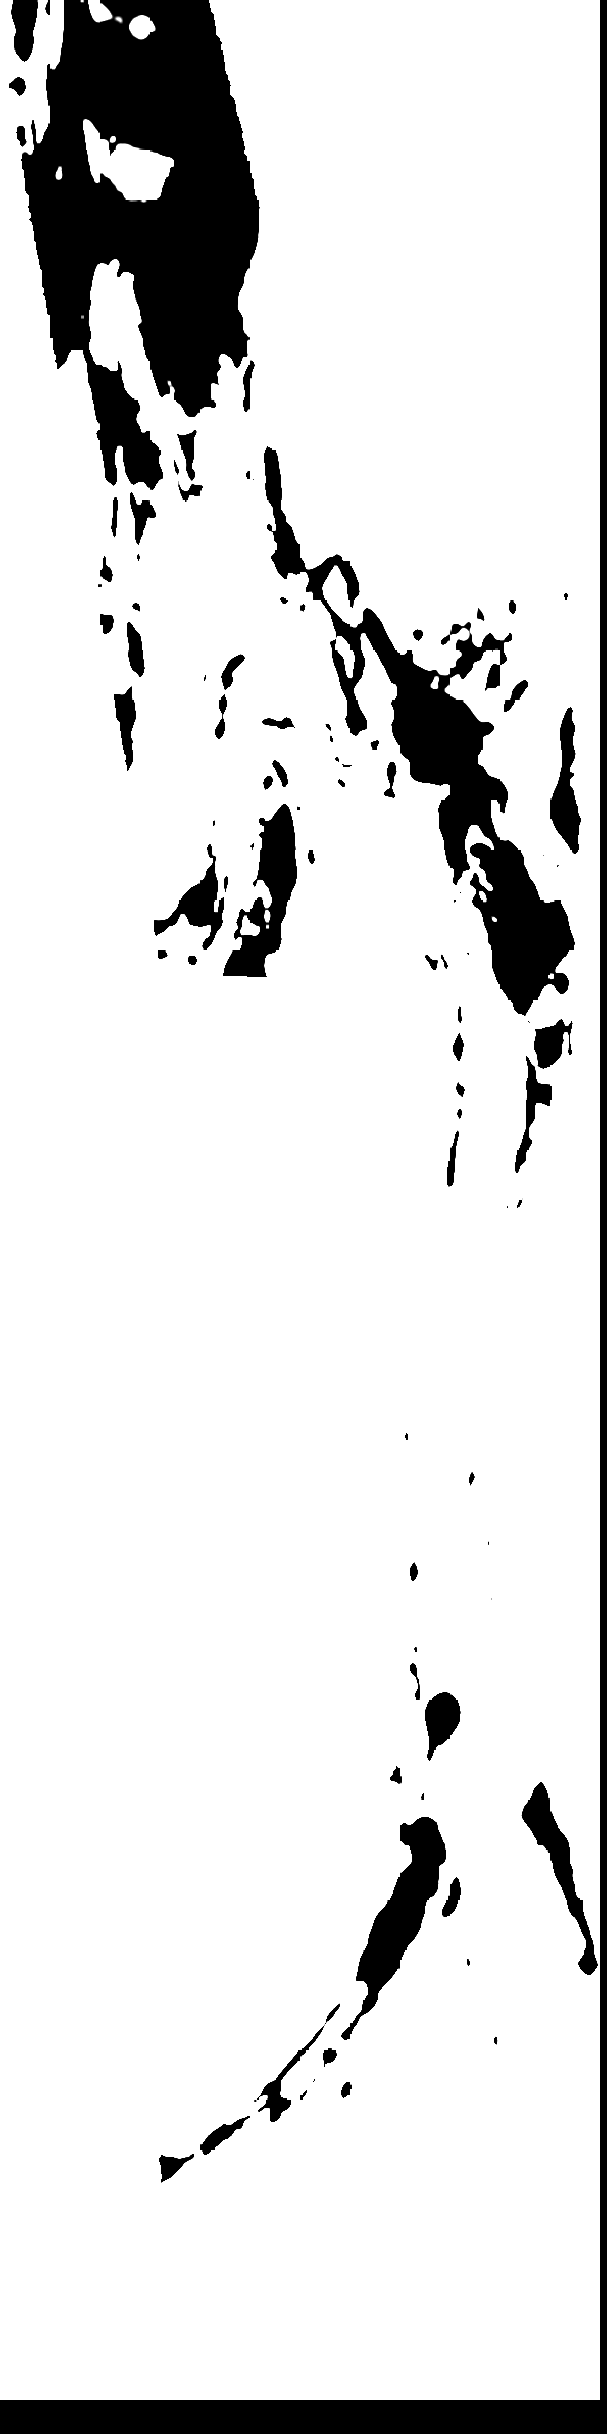

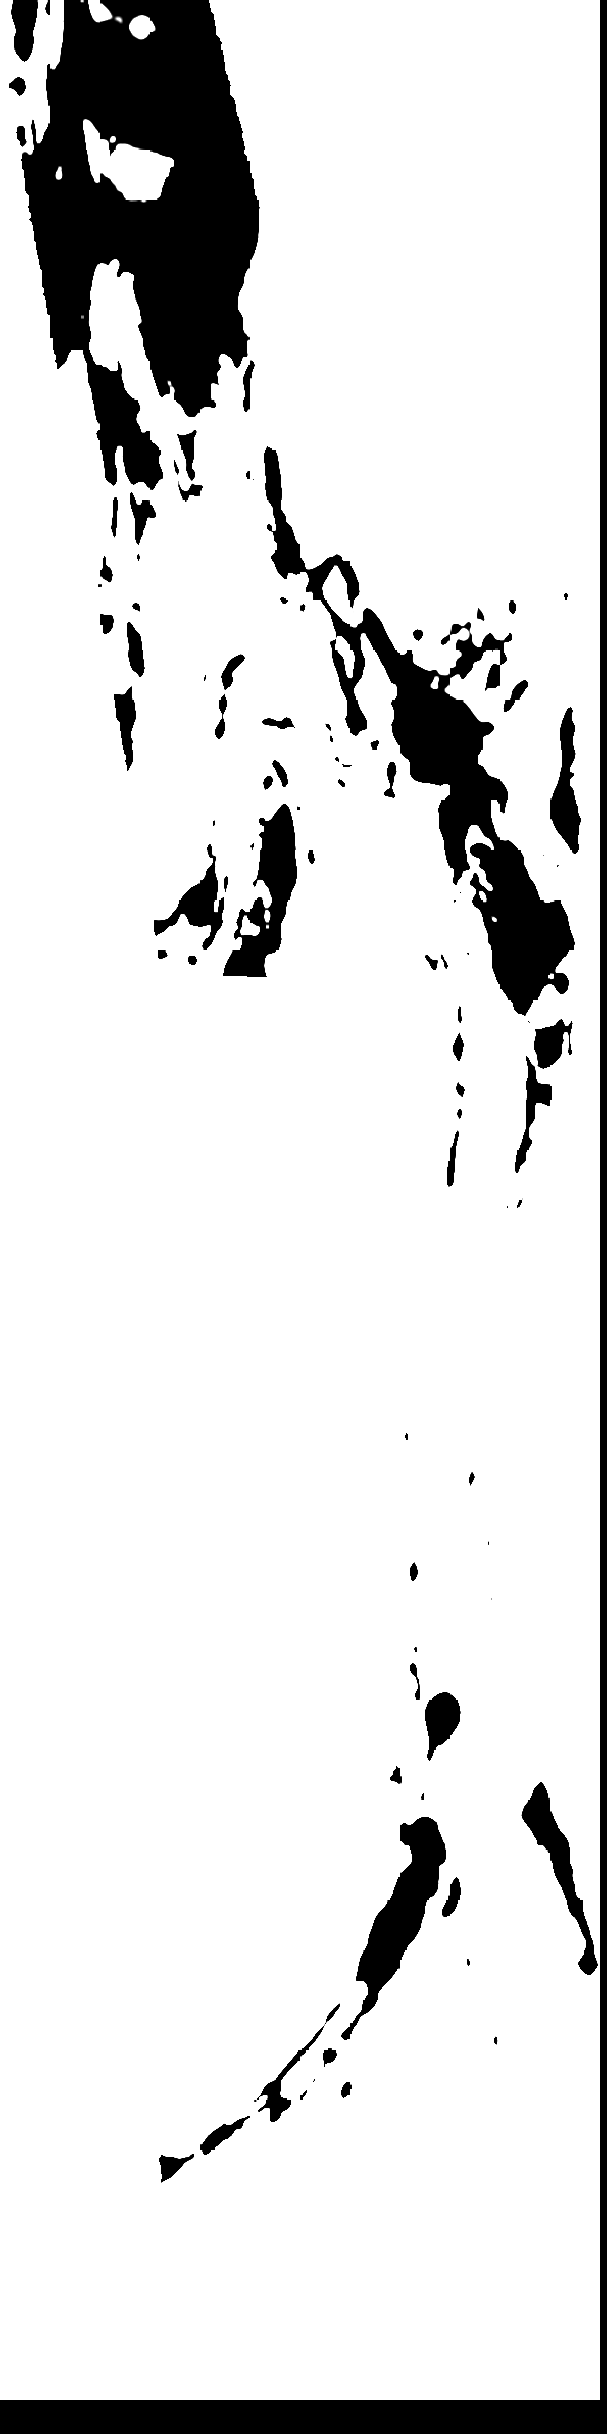

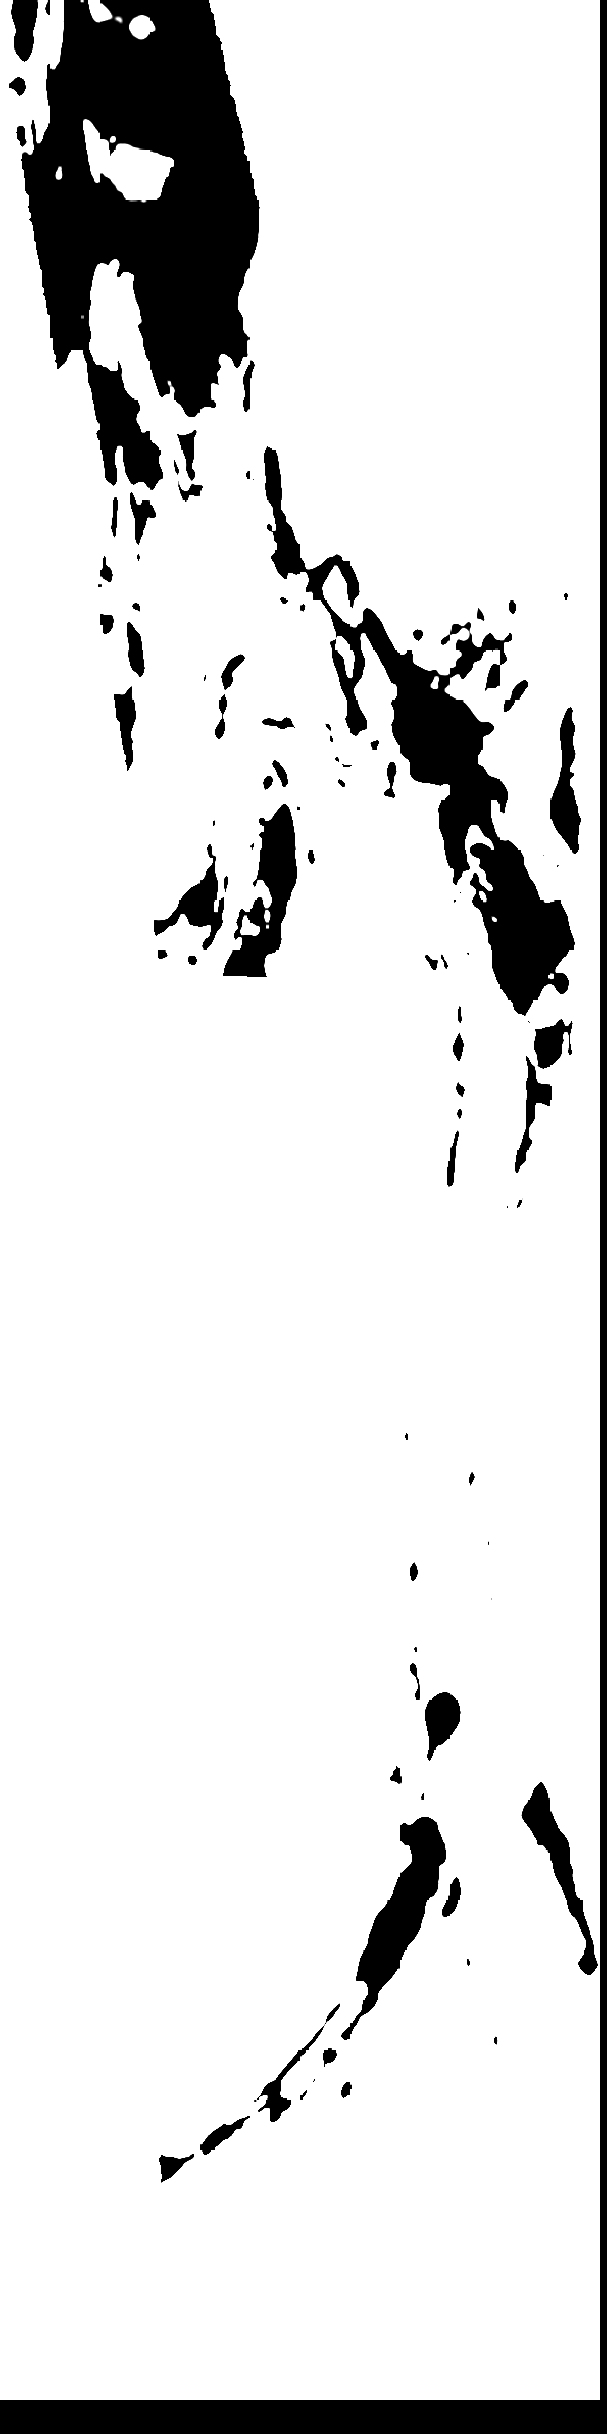

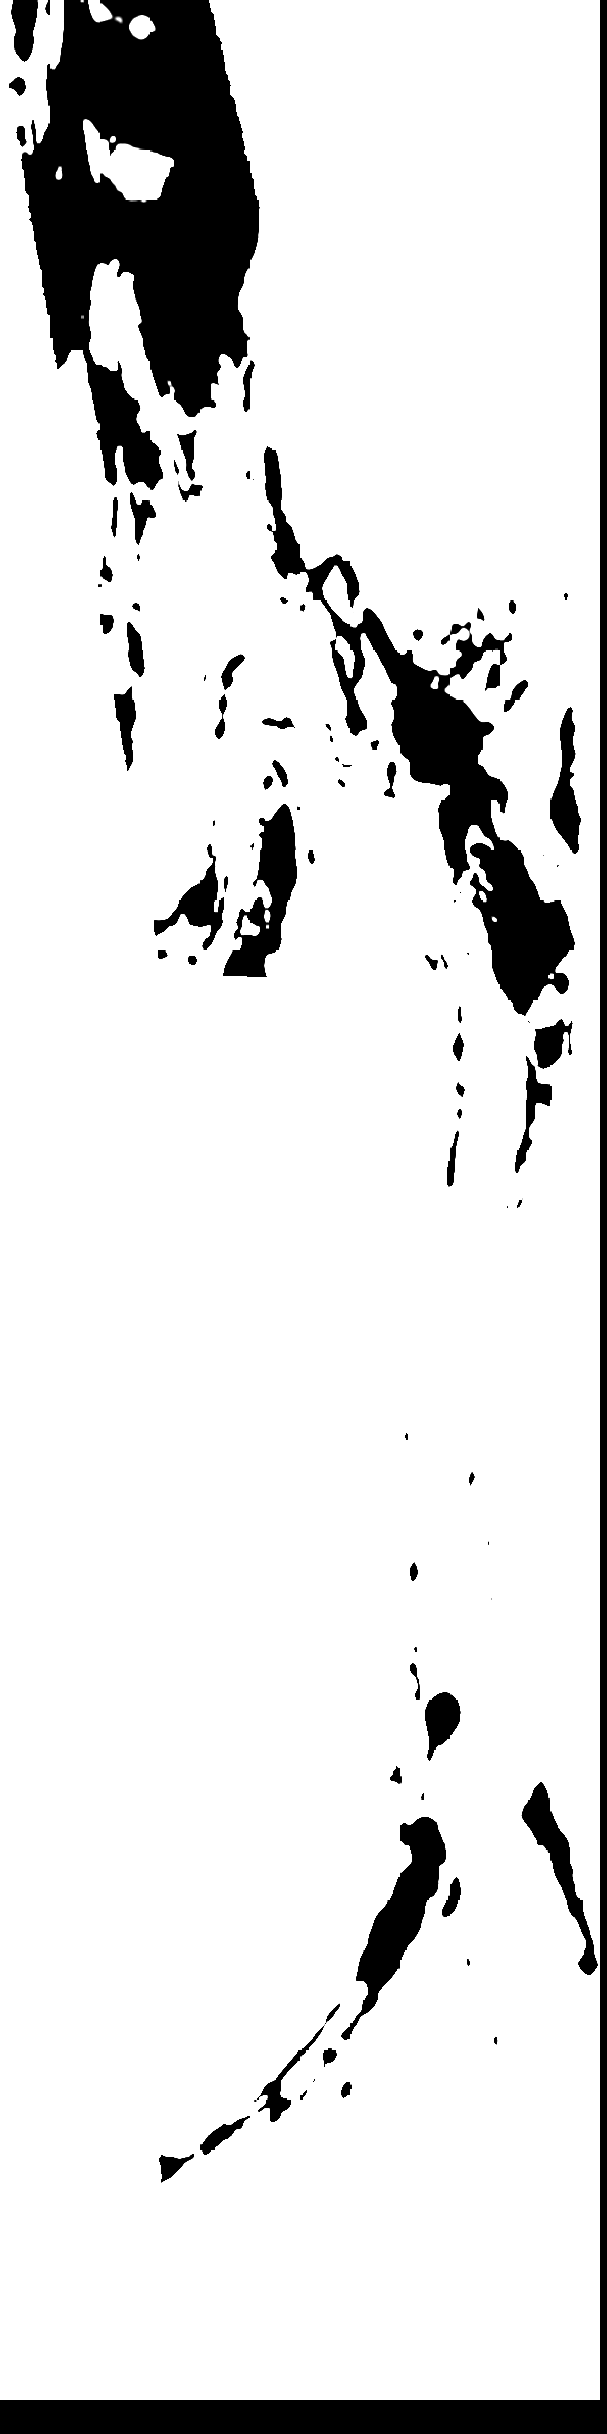

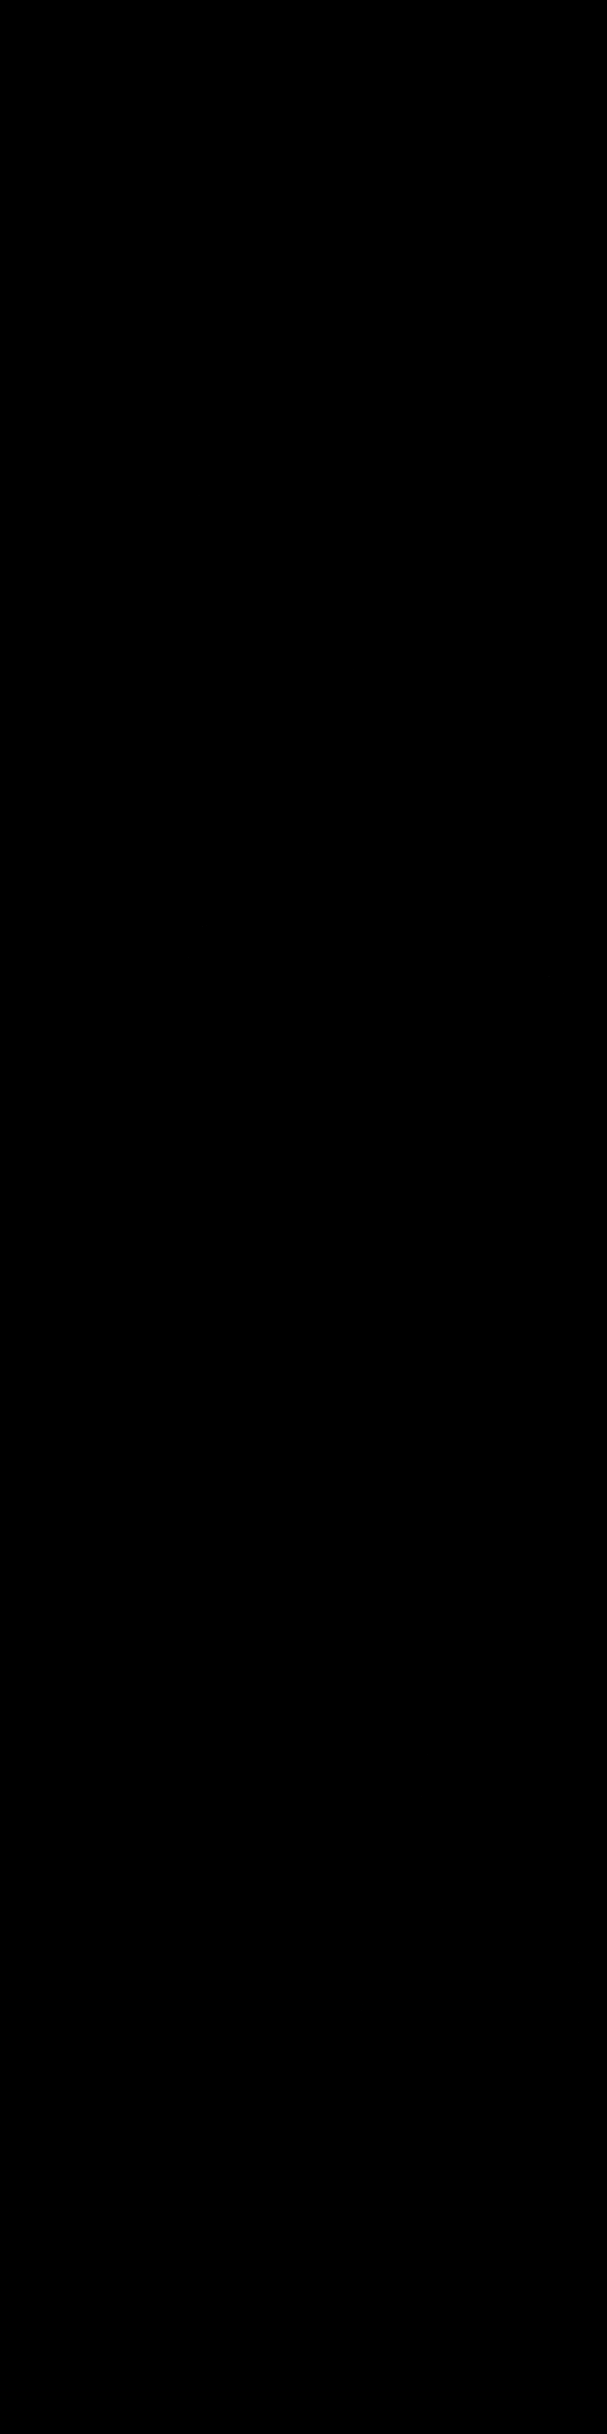

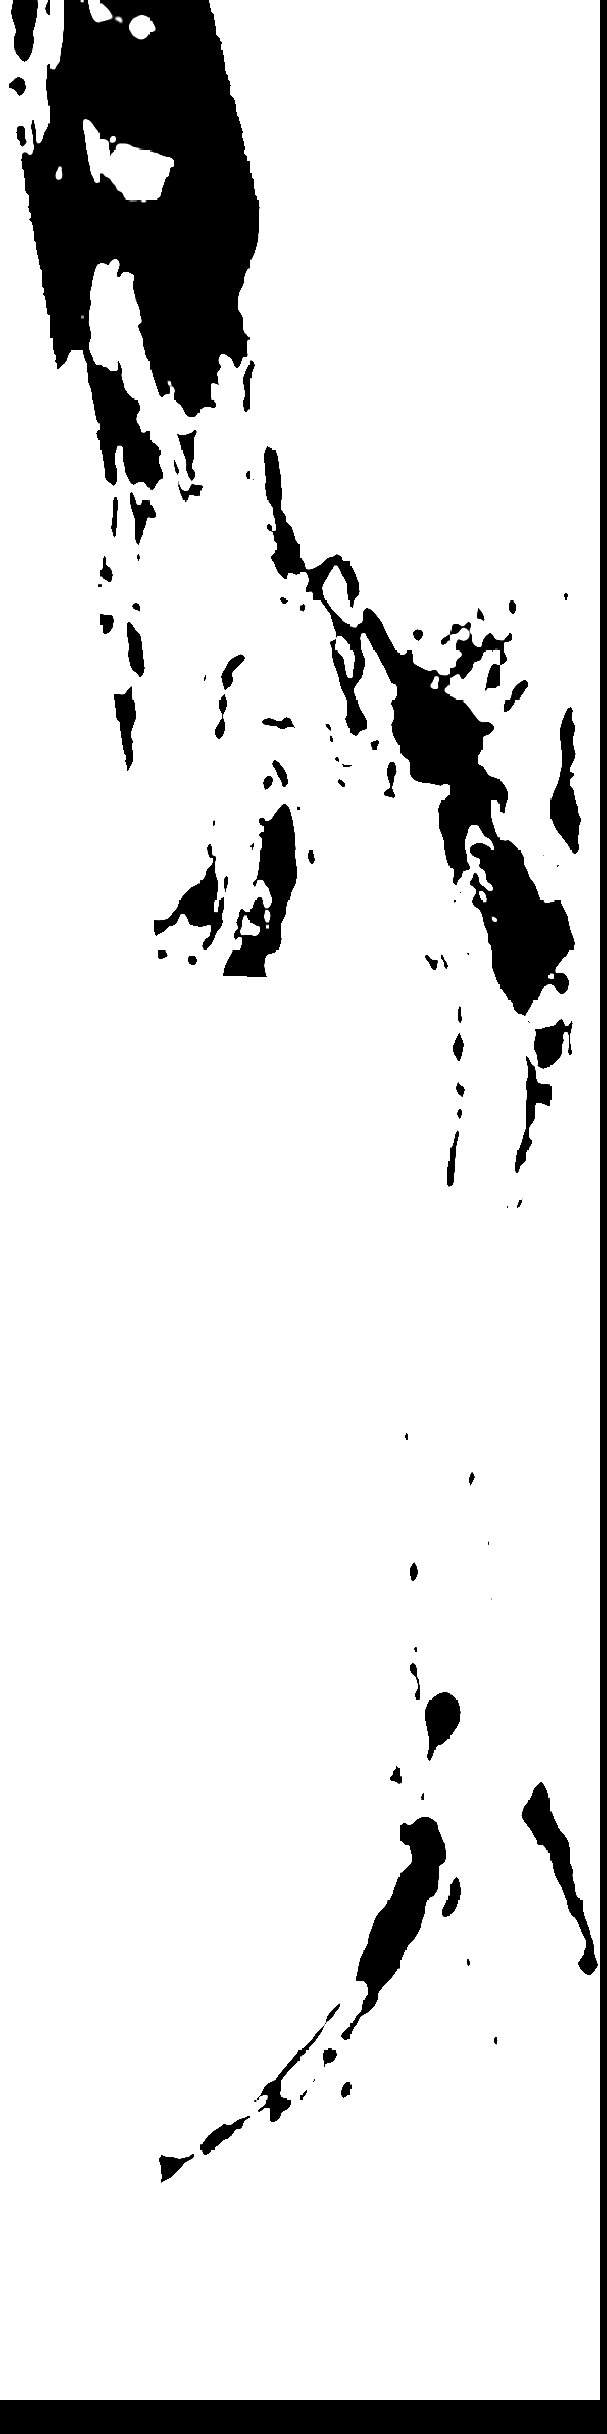

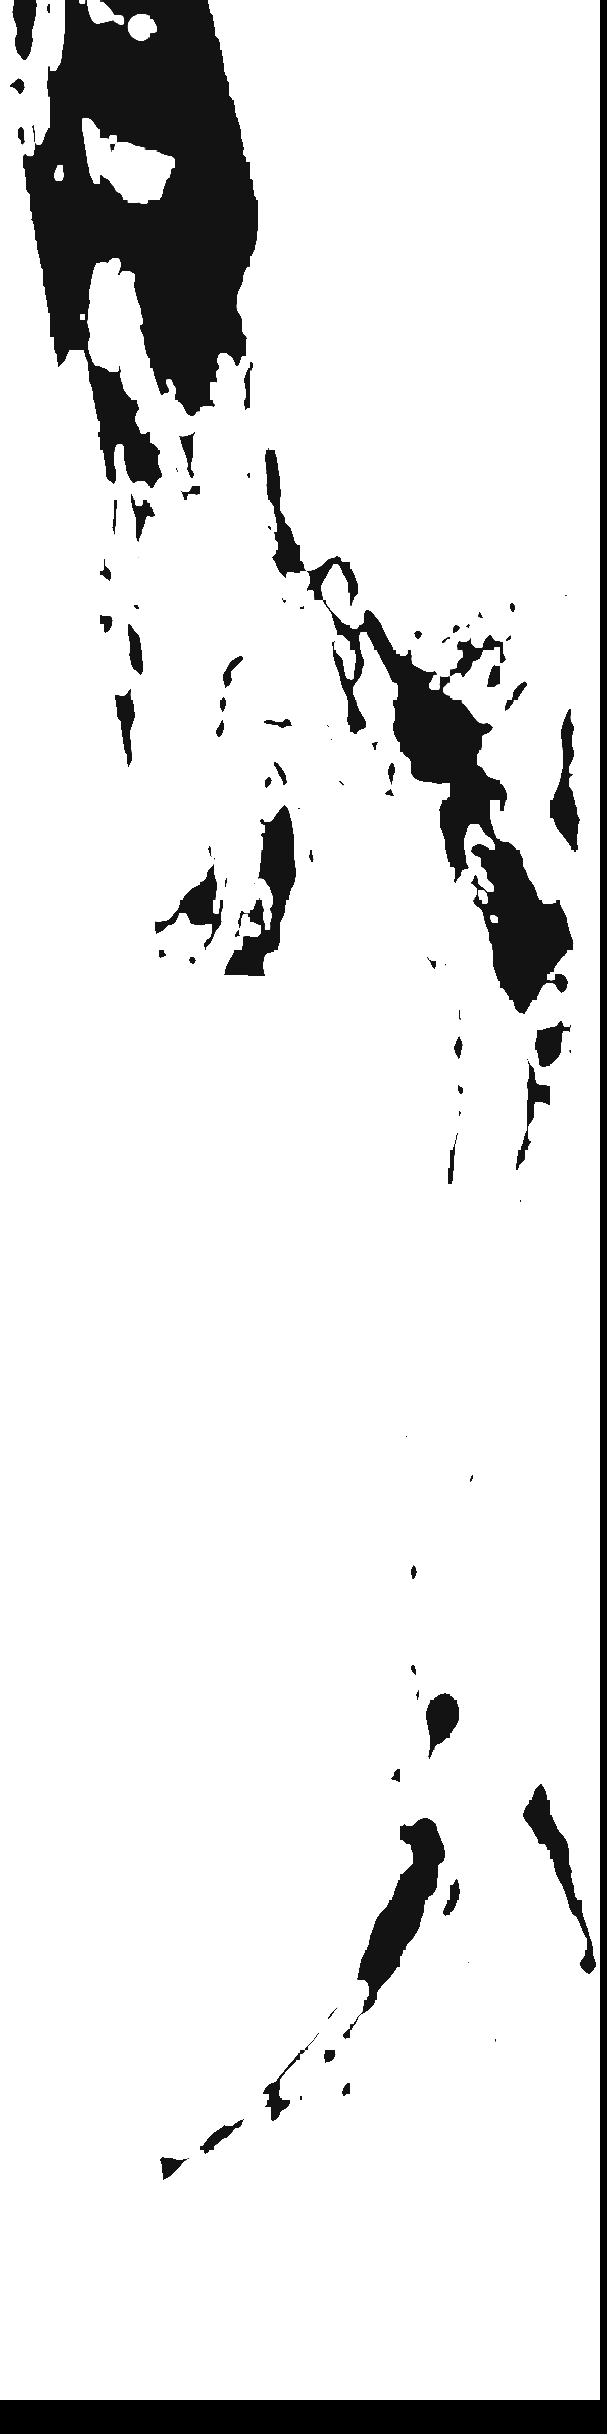

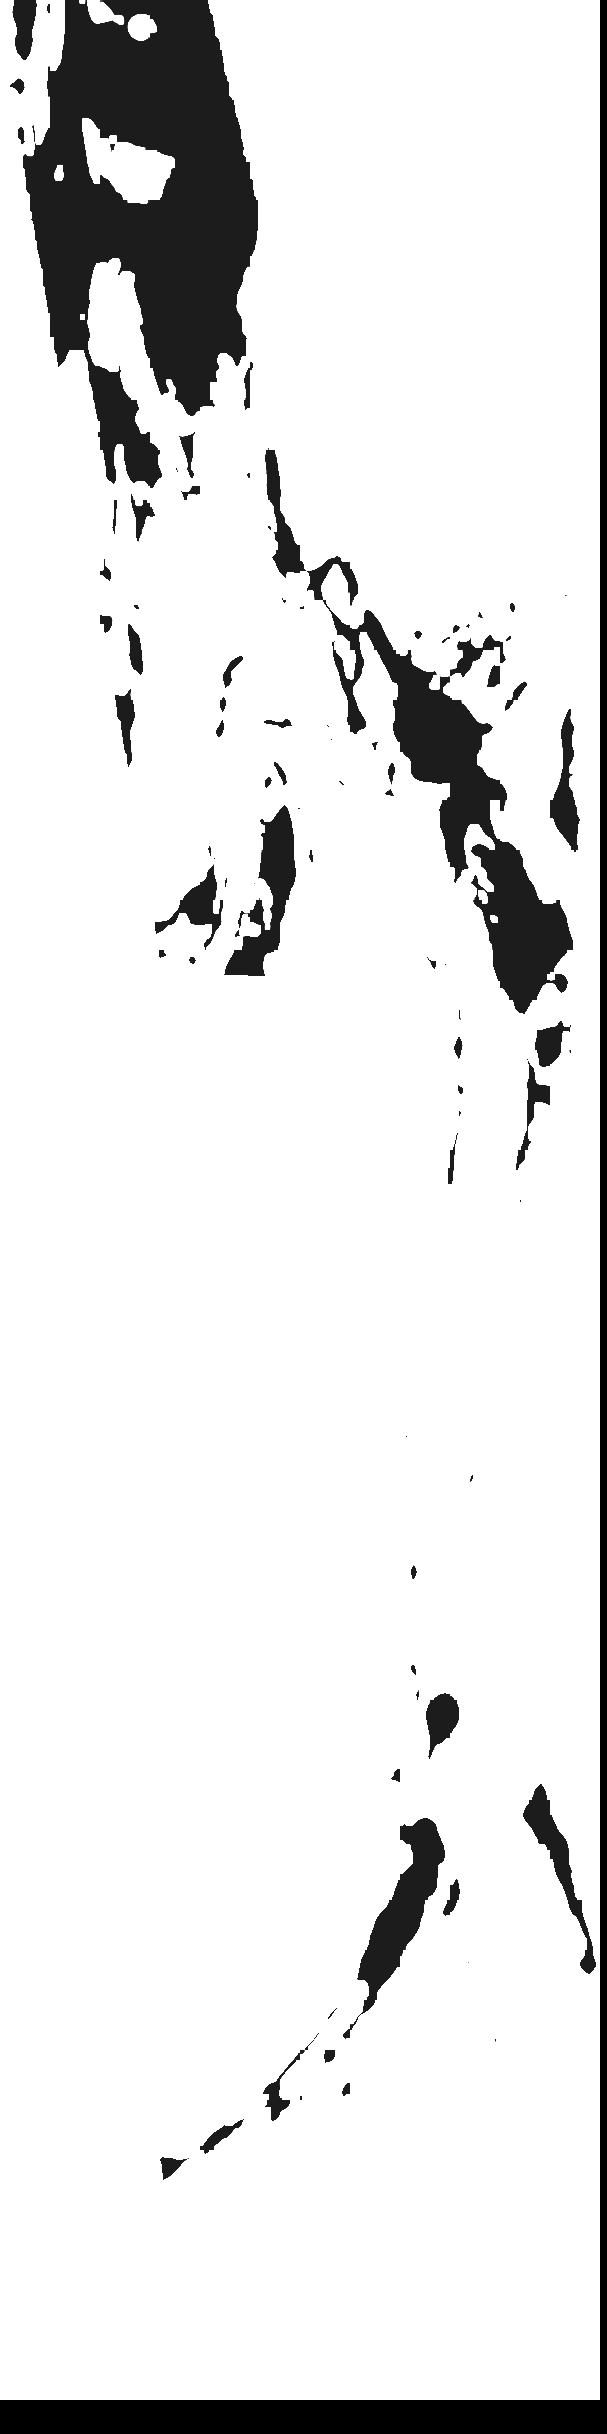

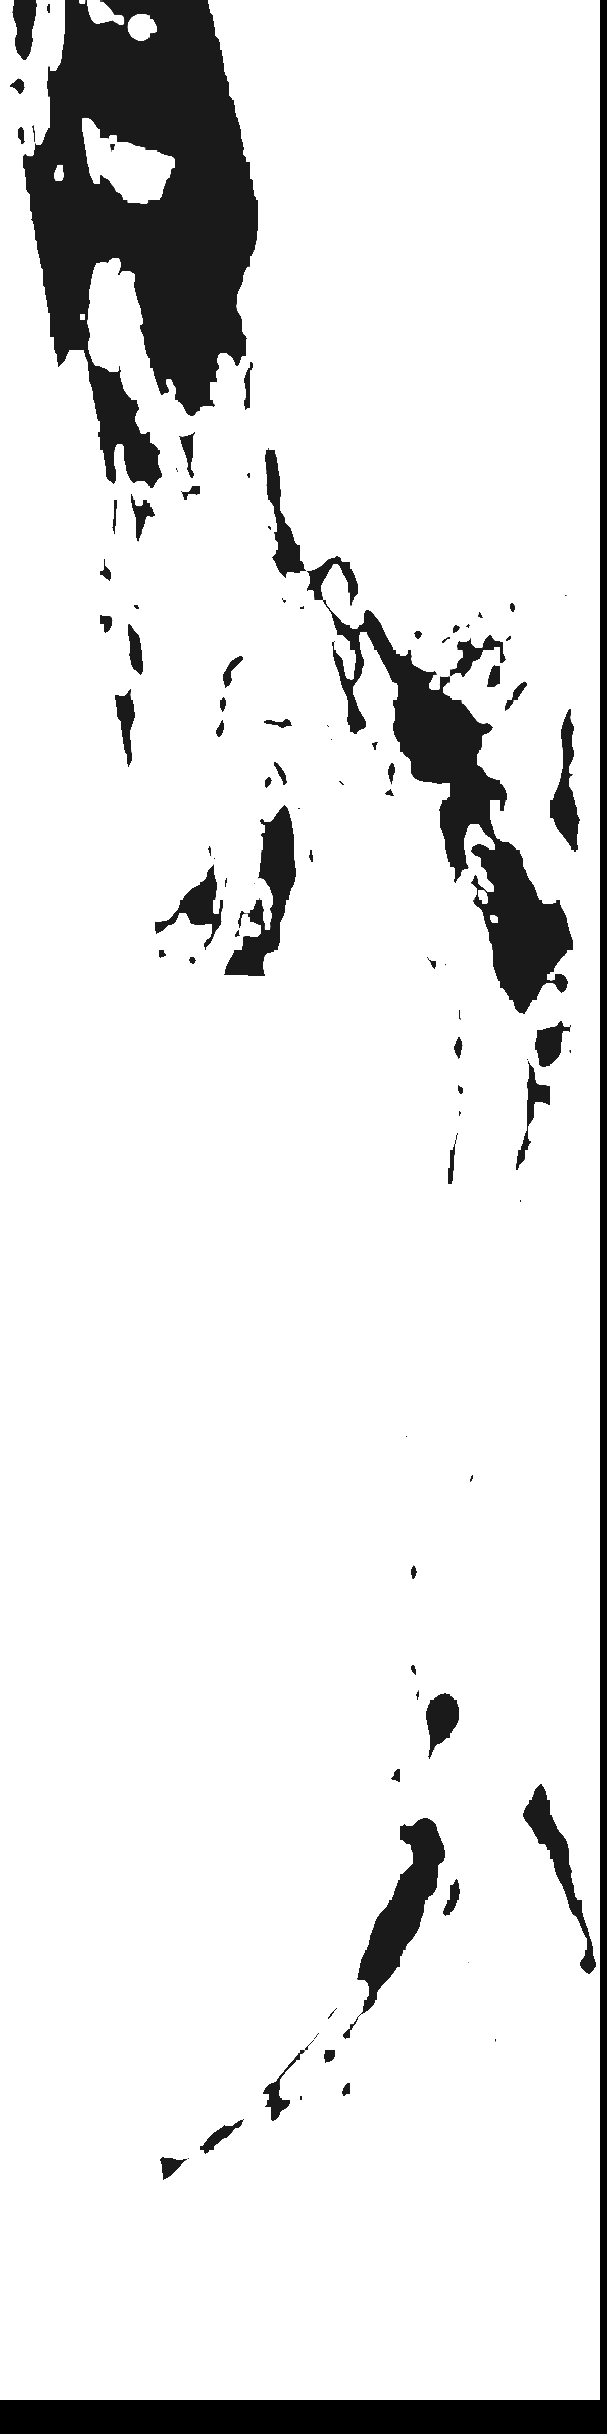

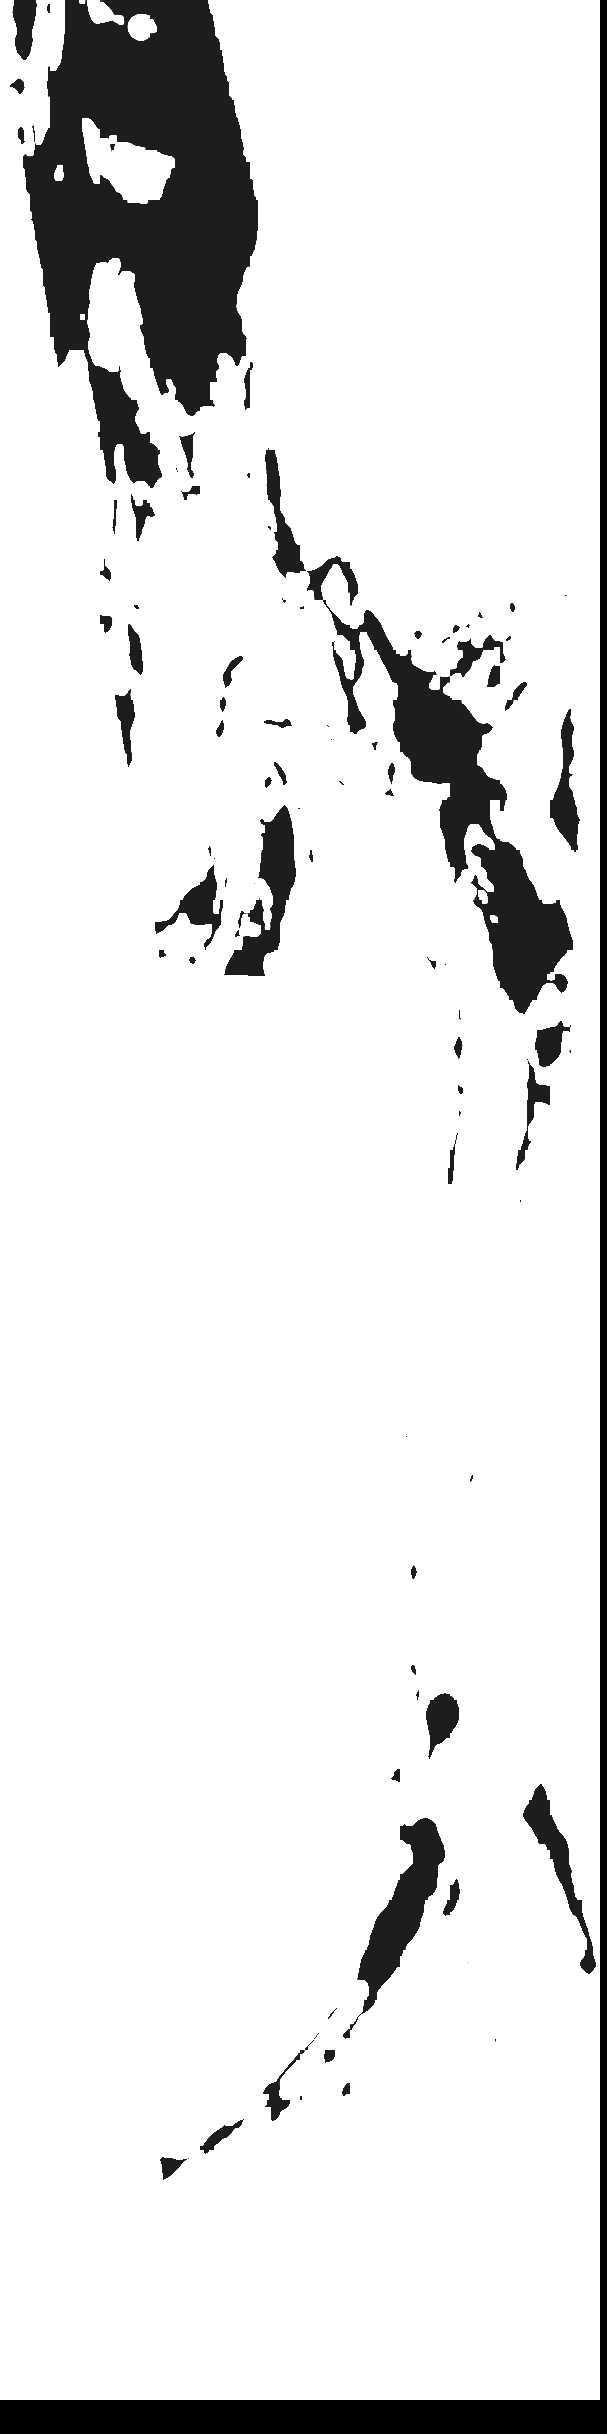

Resized and saved stitched images successfully.


In [38]:
import os
from PIL import Image

# Directory to save the images
save_dir = "/content/drive/MyDrive/IITB/Magntic_Image/stitched_outputs_v1"
os.makedirs(save_dir, exist_ok=True)

# Reshape the stitched images to match the size of the labeled image
resized_images = []
for stitched_image in stitched_images:
    resized_image = stitched_image[:label_image.shape[0], :label_image.shape[1], :]
    resized_images.append(resized_image)

# Save and display the individual layer-wise representation images
for i, stitched_image in enumerate(resized_images):
    for j in range(stitched_image.shape[2]):
        # Create a PIL image from the NumPy array
        img = Image.fromarray(stitched_image[:, :, j])

        # Convert the image to RGB mode
        img = img.convert('RGB')

        # Save the image
        save_path = os.path.join(save_dir, f"Layer_{i+1}_Channel_{j+1}.png")
        img.save(save_path)

        # Display the saved image
        img.show()

print("Resized and saved stitched images successfully.")


In [42]:
import os
import random
import numpy as np
from PIL import Image

# Define the paths
label_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/Dep_NonDepFinal.tif"
stitched_images_dir = "/content/drive/MyDrive/IITB/Magntic_Image/stitched_outputs_v1"
output_dir = "/content/drive/MyDrive/IITB/Magntic_Image/feature_patches"

# Open the label image using rasterio
with rasterio.open(label_image_path) as label_dataset:
    # Read the label image as a numpy array
    label_image = label_dataset.read(1)  # Assuming label is in the first band

# Define the classes and corresponding pixel values
class_labels = {
    "deposit": 1,
    "non_deposit": 0
}

# Define the sample size
sample_size = 5

# Initialize lists to store the sampled positions
deposit_samples = []
non_deposit_samples = []

# Iterate over the label image and sample positions
for y in range(label_image.shape[0]):
    for x in range(label_image.shape[1]):
        pixel_value = label_image[y, x]
        if pixel_value == class_labels["deposit"]:
            deposit_samples.append((x, y))
        elif pixel_value == class_labels["non_deposit"]:
            non_deposit_samples.append((x, y))

# Randomly select sample positions
deposit_samples = random.sample(deposit_samples, sample_size)
non_deposit_samples = random.sample(non_deposit_samples, sample_size)

# Create the output directories
deposit_dir = os.path.join(output_dir, "deposit")
non_deposit_dir = os.path.join(output_dir, "non-deposit")

os.makedirs(deposit_dir, exist_ok=True)
os.makedirs(non_deposit_dir, exist_ok=True)

# Retrieve the image names in the stitched images directory
image_names = os.listdir(stitched_images_dir)

# Iterate over the selected samples
for i, sample_position in enumerate(deposit_samples + non_deposit_samples):
    x, y = sample_position

    # Calculate the patch coordinates
    patch_left = max(0, x - 50)
    patch_upper = max(0, y - 50)
    patch_right = min(label_image.shape[1], x + 50)
    patch_lower = min(label_image.shape[0], y + 50)

    # Iterate over all stitched images
    for image_name in image_names:
        stitched_image_path = os.path.join(stitched_images_dir, image_name)
        stitched_image = Image.open(stitched_image_path)

        # Extract the patch
        patch = stitched_image.crop((patch_left, patch_upper, patch_right, patch_lower))

        # Determine the class label for the current sample
        if i < sample_size:
            class_label = "deposit"
        else:
            class_label = "non-deposit"

        # Create the subdirectories for the image and layer
        image_dir = os.path.join(output_dir, class_label, f"image_{i}")
        layer_dir = os.path.join(image_dir, f"layer_{image_name[:-4]}")  # Remove the extension from the image name

        os.makedirs(layer_dir, exist_ok=True)

        # Save the patch
        patch_path = os.path.join(layer_dir, f"patch_{image_name[:-4]}.jpg")  # Remove the extension from the image name
        patch.save(patch_path)
